# 1. Import Libraries 

In [35]:
import glob
import time
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import altair as alt
pd.set_option('display.max_columns', None)

import cv2

import Utility_functions as ut
import Custom_Evaluation as ce

#PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models
import torchvision.transforms as transforms

#Skorch
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping, LRScheduler, EpochScoring,ProgressBar, Checkpoint
from skorch.dataset import CVSplit, ValidSplit
from skorch.callbacks import TrainEndCheckpoint
from torch.utils.data import TensorDataset, DataLoader

#model performance
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay,top_k_accuracy_score, balanced_accuracy_score, f1_score, recall_score 

#Scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

#Distnce Matrix
from scipy.spatial import distance_matrix, distance
from scipy.special import softmax

#Supress warnings
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')

from sklearn.manifold import MDS, TSNE

import argparse
import optuna
from optuna.integration import SkorchPruningCallback

data_dir = 'C:/Dissertation/Data/'
kg_vec = 300

In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 2. Import Data

In [37]:
Final_Images_df, predicate_df = ut.AWA2DataLoader(data_dir, data_type = "ResNet101-Features", 
                                                  Resnet101Type = 1, 
                                                  animal_attributes = 'Word2Vec', 
                                                  VectorType = 'Binary')

#data_type options
#1. "ResNet101-Features" to load Extracted Resnet101 features Avg. Time - 12 secs
#2. "Images"

#Resnet101Type
# 1 - Using Resnet Features provided with data
# 2 - Using Resnet Features extracted by Abhimanyu Acharya using a pretrainied Resnet101

# animal_attribute
#1. "AwA2" - As provided with AwA2 data
#2. "Custom Animal Attribute KG" - Custom KGs
#3. "Custom KG Extended 01" - Custom KGs with ontology alignment
#3. "Custom KG Extended 02" - Custom KGs with ontology alignment + vector combination
#4. "Word2Vec" - word2vec-google-news-300
#4. "Word2Vec Extended" - Extended Word2Vec
#5. "Dbnary" - Dbnary Knowledge Graph/Wiktionary (KGVec2Go Wiktionary/DBnary)
#6. "DBpedia" - DBPedia Knowledge Graph (KGVec2Go Classic RDF2vec: 500 walks, depth: 4, SG, 200 dimensions)
#7. "WordNet" - WordNet Knowledge Graph (KGVec2Go WordNet)
#8. "Custom Animal Attribute KG Extended" - Extended Custom KGs

Using Resnet101 Features provided with data
Animal Attributes Included - Binary Vector
Word2Vec Animal Attributes Included
Execution time: 13.482839107513428 seconds


# 3. Split Data in Predefined Test, Train & Validation for ZSL

In [38]:
trainval_df, TrainData01, ValData01, TrainData02, ValData02, TrainData03, ValData03, Seen_test_df, Unseen_test_df = ut.TestTrainValsplitdata_dir(data_dir, Final_Images_df)

  Training - Validation Split 01 
 Train Classes  
 Number of Classes 27 
 ['antelope' 'buffalo' 'chihuahua' 'collie' 'cow' 'elephant' 'fox'
 'german+shepherd' 'grizzly+bear' 'hippopotamus' 'humpback+whale'
 'killer+whale' 'lion' 'mouse' 'otter' 'persian+cat' 'pig' 'polar+bear'
 'rhinoceros' 'siamese+cat' 'skunk' 'spider+monkey' 'squirrel' 'tiger'
 'weasel' 'wolf' 'zebra'] 

 Validation Classes  
 Number of Classes 13 
 ['beaver' 'chimpanzee' 'dalmatian' 'deer' 'giant+panda' 'gorilla'
 'hamster' 'leopard' 'mole' 'moose' 'ox' 'rabbit' 'raccoon'] 

  Training - Validation Split 02 
 Train Classes  
 Number of Classes 27 
 ['buffalo' 'chimpanzee' 'collie' 'cow' 'deer' 'elephant' 'german+shepherd'
 'giant+panda' 'gorilla' 'hamster' 'hippopotamus' 'humpback+whale'
 'leopard' 'lion' 'mole' 'moose' 'mouse' 'polar+bear' 'rabbit' 'raccoon'
 'rhinoceros' 'siamese+cat' 'spider+monkey' 'squirrel' 'tiger' 'weasel'
 'wolf'] 

 Validation Classes  
 Number of Classes 13 
 ['antelope' 'beaver' 'chihua

# 4. Define Dependent and Independent variables 

In [39]:
# Pre defined Test split 01
X1 = TrainData01.iloc[:,1:2049]
y1 = TrainData01.iloc[:,-kg_vec:]

# Pre defined Test split 02
X2 = TrainData02.iloc[:,1:2049]
y2 = TrainData02.iloc[:,-kg_vec:]

# Pre defined Test split 03
X3 = TrainData03.iloc[:,1:2049]
y3 = TrainData03.iloc[:,-kg_vec:]

X_finaltrain = trainval_df.iloc[:,1:2049]
y_finaltrain = trainval_df.iloc[:,-kg_vec:]

In [40]:
#Train val split for testing projection network
X_train1,X_val_seen_classes1,y_train1,y_val_seen_classes1 = train_test_split(X1,y1,stratify=y1,test_size=0.1,random_state = 0)

X_train2,X_val_seen_classes2,y_train2,y_val_seen_classes2 = train_test_split(X2,y2,stratify=y2,test_size=0.1,random_state = 0)

X_train3,X_val_seen_classes3,y_train3,y_val_seen_classes3 = train_test_split(X3,y3,stratify=y3,test_size=0.1,random_state = 0)

#Stratify Final train data 
X_train_final,X_val_seen_classes_final,y_train_final,y_val_seen_classes_final = train_test_split(X_finaltrain,y_finaltrain,stratify=y_finaltrain,test_size=0.002,random_state = 0)

# 5. Define Animal Attributes

In [41]:
animal_attributes_df = pd.read_csv("C:/Dissertation/Data/AwA2-data/Animals_with_Attributes2/predicates.txt", sep = '\t',header = None, names = ['predicates'])
animal_attributes_list = animal_attributes_df['predicates'].tolist()
print(animal_attributes_list)

['black', 'white', 'blue', 'brown', 'gray', 'orange', 'red', 'yellow', 'patches', 'spots', 'stripes', 'furry', 'hairless', 'toughskin', 'big', 'small', 'bulbous', 'lean', 'flippers', 'hands', 'hooves', 'pads', 'paws', 'longleg', 'longneck', 'tail', 'chewteeth', 'meatteeth', 'buckteeth', 'strainteeth', 'horns', 'claws', 'tusks', 'smelly', 'flys', 'hops', 'swims', 'tunnels', 'walks', 'fast', 'slow', 'strong', 'weak', 'muscle', 'bipedal', 'quadrapedal', 'active', 'inactive', 'nocturnal', 'hibernate', 'agility', 'fish', 'meat', 'plankton', 'vegetation', 'insects', 'forager', 'grazer', 'hunter', 'scavenger', 'skimmer', 'stalker', 'newworld', 'oldworld', 'arctic', 'coastal', 'desert', 'bush', 'plains', 'forest', 'fields', 'jungle', 'mountains', 'ocean', 'ground', 'water', 'tree', 'cave', 'fierce', 'timid', 'smart', 'group', 'solitary', 'nestspot', 'domestic']


# 6. Load Taxonomy Information

In [42]:
taxonomy_df = pd.read_csv("C:/Dissertation/Data/Mammal Taxonomy/Mammal Taxonomy_noduplicates.csv")
taxonomy_df.drop(['subgenus','biogeographicRealm','CMW_sciName'], axis = 1, inplace = True)
taxonomy_df.head()

,sciName,animal_label,animal_class,mainCommonName,otherCommonNames,class,infraclass,magnorder,superorder,order,suborder,infraorder,parvorder,superfamily,family,subfamily,tribe,genus
0,Antilope_cervicapra,1,antelope,Blackbuck,Indian Antelope,Mammalia,Placentalia,Boreoeutheria,Laurasiatheria,ARTIODACTYLA,RUMINANTIA,PECORA,NaN,NaN,BOVIDAE,ANTILOPINAE,ANTILOPINI,Antilope
1,Ursus_arctos,2,grizzly+bear,Brown Bear,Grizzly Bear|Kodiak Bear,Mammalia,Placentalia,Boreoeutheria,Laurasiatheria,CARNIVORA,CANIFORMIA,ARCTOIDEA,NaN,URSOIDEA,URSIDAE,URSINAE,NaN,Ursus
2,Orcinus_orca,3,killer+whale,Killer Whale,Orca,Mammalia,Placentalia,Boreoeutheria,Laurasiatheria,ARTIODACTYLA,WHIPPOMORPHA,CETACEA,ODONTOCETI,DELPHINOIDEA,DELPHINIDAE,INCERTAE SEDIS,NaN,Orcinus
3,Aplodontia_rufa,4,beaver,Mountain Beaver,Boomer|Sewellel|Point Arena Mountain Beaver|Po...,Mammalia,Placentalia,Boreoeutheria,Euarchontoglires,RODENTIA,SCIUROMORPHA,NaN,NaN,NaN,APLODONTIIDAE,NaN,NaN,Aplodontia
4,Canis_familiaris,5,dalmatian,Domestic Dog,Dog|Dingo|Feral Dog|New Guinea Singing Dog|Vil...,Mammalia,Placentalia,Boreoeutheria,Laurasiatheria,CARNIVORA,CANIFORMIA,CANOIDEA,NaN,NaN,CANIDAE,NaN,NaN,Canis


# 7. Set up Neural Network for multilabel classifciation

### 7.1 Define DNN for projection network

In [43]:
class ProjectionNetwork1(nn.Module):
    def __init__(self, num_units, non_linear,dropout):
        super(ProjectionNetwork1, self).__init__()        
        self.fc1 = nn.Linear(2048, num_units)  
        self.fc2 = nn.Linear(num_units, kg_vec) 
        self.nonlinear = non_linear  
        self.dropout = nn.Dropout(dropout)
                        
    def forward(self, x):
        out = self.fc1(x)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out   

In [44]:
class ProjectionNetwork2(nn.Module):
    def __init__(self, num_units, non_linear,dropout):
        super(ProjectionNetwork2, self).__init__()        
        self.fc1 = nn.Linear(2048, num_units)  
        self.fc2 = nn.Linear(num_units, num_units) 
        self.fc3 = nn.Linear(num_units, kg_vec) 
        self.nonlinear = non_linear  
        self.dropout = nn.Dropout(dropout)
                        
    def forward(self, x):
        out = self.fc1(x)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc3(out)
        return out   

In [45]:
class ProjectionNetwork3(nn.Module):
    def __init__(self, num_units, non_linear,dropout):
        super(ProjectionNetwork3, self).__init__()        
        self.fc1 = nn.Linear(2048, num_units)  
        self.fc2 = nn.Linear(num_units, num_units) 
        self.fc3 = nn.Linear(num_units, num_units) 
        self.fc4 = nn.Linear(num_units, kg_vec) 
        self.nonlinear = non_linear  
        self.dropout = nn.Dropout(dropout)
                        
    def forward(self, x):
        out = self.fc1(x)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc3(out)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc4(out)
        return out   

### 7.2 Define evaluation criterea and checkpoint for projection network

In [46]:
# Create Skorch EPOCHScoring   
train_macro_recall_score = EpochScoring(scoring='recall_macro', lower_is_better=False, name = 'train_recall_macro', on_train = True)
valid_macro_recall_score = EpochScoring(scoring='recall_macro', lower_is_better=False, name = 'valid_recall_macro', on_train = False)

# Create Checkpoint
CP1 = Checkpoint(monitor='valid_loss_best',dirname='exp1')
CP2 = Checkpoint(monitor='valid_loss_best',dirname='exp2')
CP3= Checkpoint(monitor='valid_loss_best',dirname='exp3')
CP_final= Checkpoint(monitor='valid_loss_best',dirname='exp_final')

### 7.3 Check for GPU

In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
torch.cuda.empty_cache()
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
NVIDIA GeForce RTX 3060 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


### 7.4 Define Conventiona Zero Shot Leaning Function

In [48]:
def CZSL(mode, split, DNN, epochs, bs, numunits, lr, optimiser, dropout, mom, wd, device, checkpoint, pred_type, dist_type):
    torch.manual_seed(0)    
    
    if mode == "Train":
        if split == 1:
            X = X_train1.astype(np.float32).values
            y = y_train1.astype(np.float32).values
            SeenClassFeatures = X_val_seen_classes1
            SeenClassAttributes = y_val_seen_classes1
            UnseenData = ValData01
            
        if split == 2:
            X = X_train2.astype(np.float32).values
            y = y_train2.astype(np.float32).values
            SeenClassFeatures = X_val_seen_classes2
            SeenClassAttributes = y_val_seen_classes2
            UnseenData = ValData02
            
        if split == 3:
            X = X_train3.astype(np.float32).values
            y = y_train3.astype(np.float32).values
            SeenClassFeatures = X_val_seen_classes3
            SeenClassAttributes = y_val_seen_classes3
            UnseenData = ValData03
       
        
    if mode == "Test":
        X = X_train_final.astype(np.float32).values
        y = y_train_final.astype(np.float32).values        
        UnseenData = Unseen_test_df
    
    #Model 01
    net = NeuralNetClassifier(
    DNN,
    batch_size= bs,
    module__num_units = numunits,
    module__non_linear = optimiser,
    module__dropout = dropout,
    max_epochs=epochs,
    lr=lr,
    criterion = torch.nn.modules.loss.BCEWithLogitsLoss, 
    optimizer=torch.optim.SGD,
    optimizer__momentum = mom,
    optimizer__weight_decay = wd,
    train_split = ValidSplit(5),
    callbacks=[train_macro_recall_score,valid_macro_recall_score, checkpoint],
    callbacks__valid_acc=None,
    device= device
    )     
    
    #Train three models of three Train Val spilts
    print('Training DNN')
    st = time.time()   
    net.fit(X,y)
    et = time.time()
    elapsed_time = et - st
    print('Execution time:', elapsed_time, 'seconds')
    
    #Plot training val curves
    print('Training Validation Loss Curve')
    train_loss = net.history[:, 'train_loss']
    valid_loss = net.history[:, 'valid_loss']
    plt.figure(figsize=(10,5))
    plt.plot(train_loss, 'o-', label='training')
    plt.plot(valid_loss, 'o-', label='validation')
    plt.xlabel('Number of Epochs', fontsize=10)
    plt.ylabel('Error Loss', fontsize=10)
    plt.legend()
    plt.show() 
    
    print('Trianing Recall Macro Curve')
    train_loss = net.history[:, 'train_recall_macro']
    valid_loss = net.history[:, 'valid_recall_macro']
    plt.figure(figsize=(10,5))
    plt.plot(train_loss, 'o-', label='training')
    plt.plot(valid_loss, 'o-', label='validation')
    plt.xlabel('Number of Epochs', fontsize=10)
    plt.ylabel('F1 Score (Macro)', fontsize=10)
    plt.legend()
    plt.show() 
    
    #load best model weights
    net.load_params(checkpoint=checkpoint)  
 
    #predict attributes for Seen classes
    if mode == "Train":
        predicted_attributes = net.predict(SeenClassFeatures.astype(np.float32).values)
        #print attribute prediction DNN performance
        #print(classification_report(SeenClassAttributes.astype(np.float32).values, predicted_attributes, target_names=animal_attributes_list))    
        
        print("Recall (Macro)")
        print(recall_score(SeenClassAttributes.astype(np.float32).values, predicted_attributes, average='macro'))
    
    if mode == "Test":
        pass

    #predict attributes for Unseen classes 
    y_pred_unseen = net.predict(UnseenData.iloc[:,1:2049].astype(np.float32).values)
    y_pred_unseen_proba = net.predict_proba(UnseenData.iloc[:,1:2049].astype(np.float32).values)
    
    #limit search space to unseen classes 
    predicatedf_CZSL = predicate_df[predicate_df['classes'].isin((UnseenData.classes.unique()).tolist())]
    animal_attributes = np.array(predicatedf_CZSL.iloc[:,-kg_vec:])
    animal_attributes_labels = predicatedf_CZSL['labels'].unique()
    print('Unseen Class Labels')
    print(animal_attributes_labels)
    
    #Spatialise the unseen classes using TSNE
    print('TSNE spatialisation of Unseen Classes')
    
    classes_df = predicatedf_CZSL.copy()
    classes_df.reset_index(inplace=True)
    
    embeddings = TSNE(n_components=2, verbose=0, random_state=123, perplexity=9.0)

    TSNE_predicates = embeddings.fit_transform(animal_attributes) 
    TSNE_predicates_df = pd.DataFrame(data = TSNE_predicates
                 , columns = ['Binary comp-1', 'Binary comp-2'])
    
    TSNE_predicates_df1 = pd.concat([TSNE_predicates_df,classes_df['classes']], axis = 1)
    TSNE_predicates_df1 = TSNE_predicates_df1.merge(taxonomy_df, how = 'inner', left_on = 'classes', right_on = 'animal_class')
    
    #By animal class
    binary_points = alt.Chart(TSNE_predicates_df1).mark_circle(size=200).encode(
    x='Binary comp-1:Q',
    y='Binary comp-2:Q',
    color=alt.Color('classes:N', scale=alt.Scale(scheme='Magma')),
    ).properties(
    width=800,
    height=800
    )

    text1 = binary_points.mark_text(
        align='left',
        baseline='middle',
        dx=7
    ).encode(
        text='classes:N'
    )

    display(binary_points.interactive() + text1)
    
    #By Taxonomy Family
    binary_points = alt.Chart(TSNE_predicates_df1).mark_circle(size=200).encode(
    x='Binary comp-1:Q',
    y='Binary comp-2:Q',
    color=alt.Color('order:N', scale=alt.Scale(scheme='Magma')),
    ).properties(
    width=800,
    height=800
    )

    text1 = binary_points.mark_text(
        align='left',
        baseline='middle',
        dx=7
    ).encode(
        text='order:N'
    )

    display(binary_points.interactive() + text1)
    
    #assign classes to unseen data by assigning label from closest class using Cosing Distance
    y_pred_unseenprob = []
    for y in y_pred_unseen_proba:
        y_pred_unseenprob.append(y[1])
        
    if pred_type == 'Probabilistic':
        dist_CZSL= (1-distance.cdist(y_pred_unseenprob, animal_attributes, dist_type))
    elif pred_type == 'Deterministic':    
        dist_CZSL= (1-distance.cdist(y_pred_unseen, animal_attributes, dist_type))
        
    CZSL_label_prediction = np.array([np.argmax(output) for output in dist_CZSL])
    
    #replace predicted labels with unseen class labels 
    if mode == "Train":
        CZSL_label_prediction = np.select([CZSL_label_prediction == 0, CZSL_label_prediction == 1, CZSL_label_prediction == 2, CZSL_label_prediction == 3
          , CZSL_label_prediction == 4, CZSL_label_prediction == 5, CZSL_label_prediction == 6, CZSL_label_prediction == 7
          , CZSL_label_prediction == 8, CZSL_label_prediction == 9, CZSL_label_prediction == 10, CZSL_label_prediction == 11
          , CZSL_label_prediction == 12], [animal_attributes_labels[0], animal_attributes_labels[1], animal_attributes_labels[2]
          , animal_attributes_labels[3], animal_attributes_labels[4], animal_attributes_labels[5]
          , animal_attributes_labels[6], animal_attributes_labels[7], animal_attributes_labels[8], animal_attributes_labels[9]
          , animal_attributes_labels[10], animal_attributes_labels[11], animal_attributes_labels[12]], CZSL_label_prediction)
    
    if mode == "Test":
        CZSL_label_prediction = np.select([CZSL_label_prediction == 0, CZSL_label_prediction == 1, CZSL_label_prediction == 2, CZSL_label_prediction == 3
          , CZSL_label_prediction == 4, CZSL_label_prediction == 5, CZSL_label_prediction == 6, CZSL_label_prediction == 7
          , CZSL_label_prediction == 8, CZSL_label_prediction == 9], [animal_attributes_labels[0], animal_attributes_labels[1], animal_attributes_labels[2]
          , animal_attributes_labels[3], animal_attributes_labels[4], animal_attributes_labels[5]
          , animal_attributes_labels[6], animal_attributes_labels[7], animal_attributes_labels[8], animal_attributes_labels[9]], CZSL_label_prediction)
        
     #sort class names 
    class_labels = UnseenData[['labels','classes', 'order', 'family']]
    class_labels.sort_values(by=['labels'], inplace=True)
    animal_classes = class_labels['classes'].unique()
    
    #Assess CZSL Model performance
    print(classification_report(UnseenData['labels'], CZSL_label_prediction, target_names = animal_classes))

    cm = confusion_matrix(UnseenData['labels'], CZSL_label_prediction)
    correct_predictions_perc = cm.diagonal()/cm.sum(axis=1)
    print("Top_1_accuracy for UnSeen Validation split 01 per class - " , correct_predictions_perc)
    print("Top_1_accuracy for UnSeen Validation split 01 - " , np.mean(correct_predictions_perc))

    # Visualize it as a heatmap
    plt.figure(figsize=(10,8))
    a = sns.heatmap(cm, annot=True, fmt='', cmap='Reds',annot_kws={"size": 10} )
    label_font = {'size':'10'}  # Adjust to fit
    a.set_xlabel('Predicted labels', fontdict=label_font);
    a.set_ylabel('Observed labels', fontdict=label_font);
    a.set_yticklabels(animal_classes)
    a.set_xticklabels(animal_classes)
    plt.yticks(rotation=0) 
    plt.xticks(rotation=90) 
    plt.show()
    
    #predict taxonomy
    predicted_taxonomy_df = pd.DataFrame(CZSL_label_prediction, columns = ['pred_labels'])
    predicted_taxonomy_df = pd.merge(predicted_taxonomy_df, taxonomy_df,  how = 'left', left_on = 'pred_labels' , right_on = 'animal_label' )
    
    Train_family_labels = UnseenData.copy()
    Train_family_labels.sort_values(by=['order'], inplace=True)
    train_animal_family = Train_family_labels['order'].unique()
    
    print(classification_report(UnseenData['order'], predicted_taxonomy_df['order'], target_names=train_animal_family))
    
    cm = confusion_matrix(UnseenData['order'], predicted_taxonomy_df['order'])
    correct_predictions_perc = cm.diagonal()/cm.sum(axis=1)
    print("Top_1_accuracy for UnSeen Validation split 01 per class - " , correct_predictions_perc)
    print("Top_1_accuracy for UnSeen Validation split 01 - " , np.mean(correct_predictions_perc))

    # Visualize it as a heatmap
    plt.figure(figsize=(10,8))
    a = sns.heatmap(cm, annot=True, fmt='', cmap='Reds',annot_kws={"size": 10} )
    label_font = {'size':'10'}  # Adjust to fit
    a.set_xlabel('Predicted labels', fontdict=label_font);
    a.set_ylabel('Observed labels', fontdict=label_font);
    a.set_yticklabels(train_animal_family)
    a.set_xticklabels(train_animal_family)
    plt.yticks(rotation=0) 
    plt.xticks(rotation=90) 
    plt.show()
    
    if mode == "Train":
        ce.per_class_top_k_accuracy_score(dist_CZSL, animal_attributes_labels, UnseenData, animal_classes, Train = True)
    if mode == "Test":
        ce.per_class_top_k_accuracy_score(dist_CZSL, animal_attributes_labels, UnseenData, animal_classes, Train = False)
        
    return dist_CZSL, animal_attributes_labels, animal_classes    

# 8. Train Model

### 8.1 Train Validation Split 01

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.3671                0.5172        0.3386                0.5249     +  2.8786
      2        0.3183                0.5556        0.2928                0.5860     +  2.6289
      3        0.2747                0.6132        0.2529                0.6381     +  2.6225
      4        0.2392                0.6576        0.2214                0.6805     +  2.7973
      5        0.2112                0.6992        0.1967                0.7239     +  2.5219
      6        0.1892                0.7359        0.1773                0.7539     +  2.7264
      7        0.1718                0.7601        0.1617                0.7730     +  2.6769
      8        0.1575                0.7763        0.1490                0.7862     +  2.4161
      9        0.1458                0.7880    

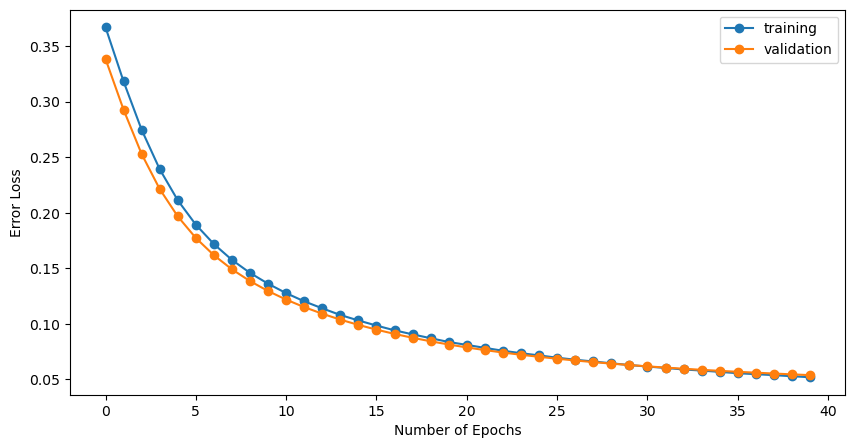

Trianing Recall Macro Curve


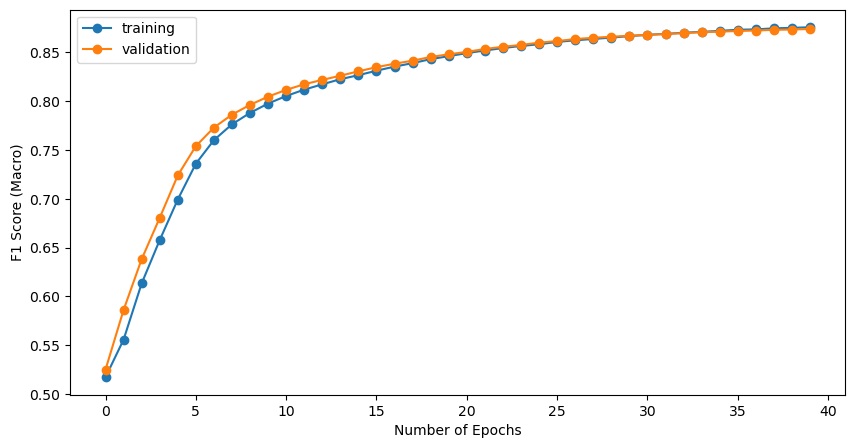

Recall (Macro)
0.8725357710754099
Unseen Class Labels
[ 4  5 12 15 16 20 21 25 26 29 39 40 48]
TSNE spatialisation of Unseen Classes


alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

      beaver       0.00      0.00      0.00       152
   dalmatian       0.19      0.92      0.32       442
        mole       0.00      0.00      0.00        75
     leopard       0.29      0.81      0.43       568
       moose       0.21      0.48      0.29       554
     gorilla       0.00      0.00      0.00       709
          ox       0.96      0.12      0.22       588
  chimpanzee       0.00      0.00      0.00       566
     hamster       0.49      0.30      0.37       640
      rabbit       0.53      0.54      0.54       877
 giant+panda       0.00      0.00      0.00       692
        deer       0.06      0.00      0.00      1069
     raccoon       0.19      0.48      0.27       408

    accuracy                           0.28      7340
   macro avg       0.23      0.28      0.19      7340
weighted avg       0.25      0.28      0.20      7340

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.         0.916289

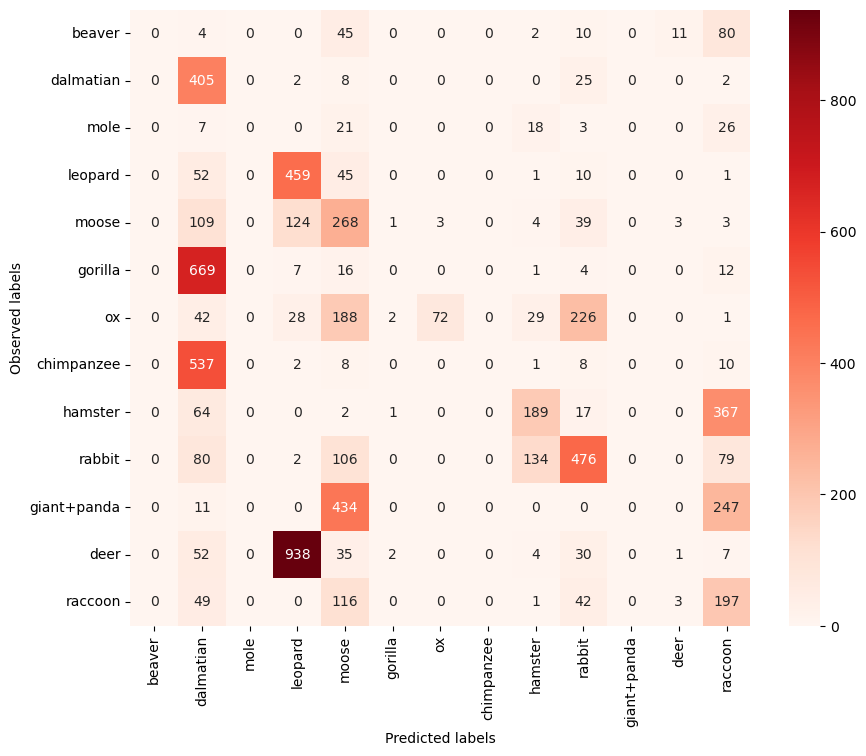

              precision    recall  f1-score   support

ARTIODACTYLA       0.41      0.26      0.32      2211
   CARNIVORA       0.30      0.68      0.42      2110
EULIPOTYPHLA       0.00      0.00      0.00        75
  LAGOMORPHA       0.53      0.54      0.54       877
    PRIMATES       0.00      0.00      0.00      1275
    RODENTIA       0.50      0.24      0.32       792

    accuracy                           0.36      7340
   macro avg       0.29      0.29      0.27      7340
weighted avg       0.33      0.36      0.32      7340

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.2578019  0.67535545 0.         0.54275941 0.         0.24116162]
Top_1_accuracy for UnSeen Validation split 01 -  0.2861797288435138


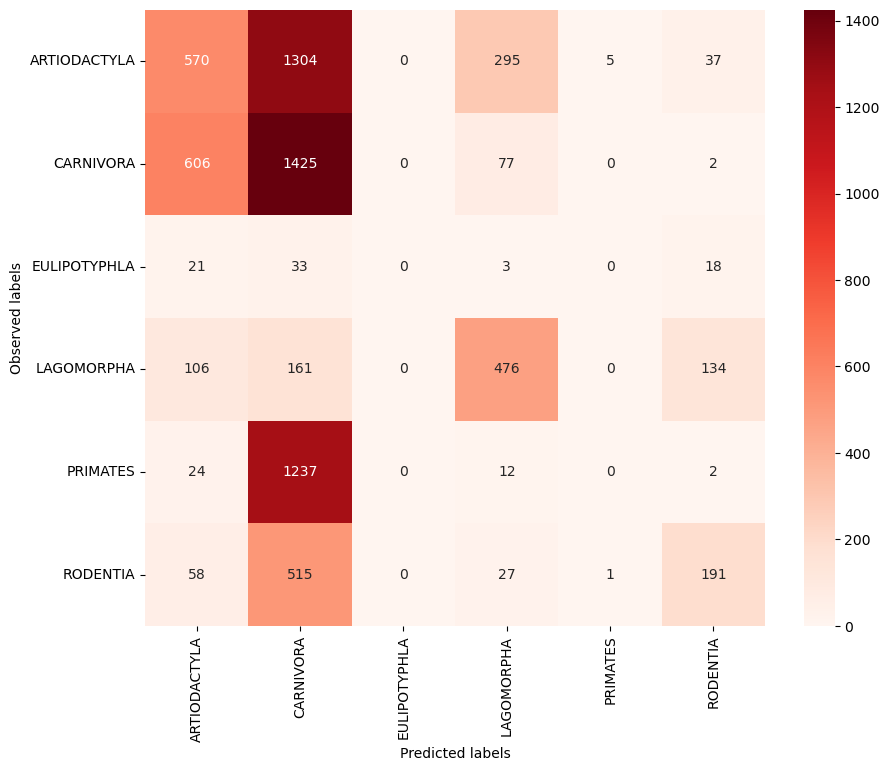

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.4241106022500686 
              0         1
0        beaver  0.019737
1     dalmatian  0.952489
2          mole  0.000000
3       leopard  0.913732
4         moose  0.711191
5       gorilla  0.008463
6            ox  0.353741
7    chimpanzee  0.000000
8       hamster  0.612500
9        rabbit  0.720639
10  giant+panda  0.000000
11         deer  0.441534
12      raccoon  0.779412 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.5304132230686953 
              0         1
0        beaver  0.171053
1     dalmatian  0.988688
2          mole  0.000000
3       leopard  0.940141
4         moose  0.842960
5       gorilla  0.062059
6            ox  0.681973
7    chimpanzee  0.000000
8       hamster  0.723437
9        rabbit  0.901938
10  giant+panda  0.000000
11         deer  0.637044
12      raccoon  0.946078 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.6252314245289902 
              0         1
0        beaver  0.460526
1     

In [49]:
Train01 = CZSL(mode = "Train", 
               split = 1, 
               DNN = ProjectionNetwork1, 
               epochs = 40, 
               bs = 8, 
               numunits = 1024, 
               lr = 0.1, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.2, 
               mom = 0, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP1, 
               pred_type = 'Probabilistic', 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

### 8.2 Train Validation Split 02

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.3715                0.5184        0.3441                0.5276     +  2.8352
      2        0.3218                0.5521        0.2965                0.5782     +  2.7654
      3        0.2753                0.6125        0.2546                0.6382     +  2.8199
      4        0.2381                0.6673        0.2227                0.6878     +  2.8408
      5        0.2101                0.7144        0.1982                0.7319     +  2.6028
      6        0.1883                0.7514        0.1787                0.7638     +  2.6813
      7        0.1707                0.7770        0.1627                0.7858     +  2.6488
      8        0.1561                0.7941        0.1495                0.8004     +  2.8243
      9        0.1442                0.8056    

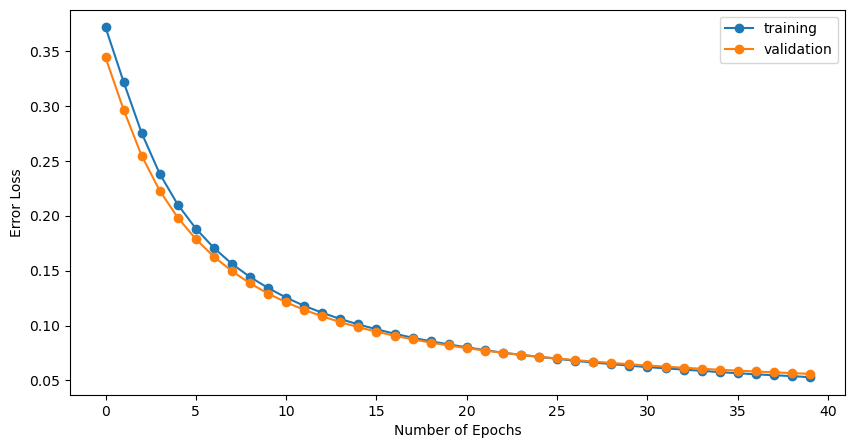

Trianing Recall Macro Curve


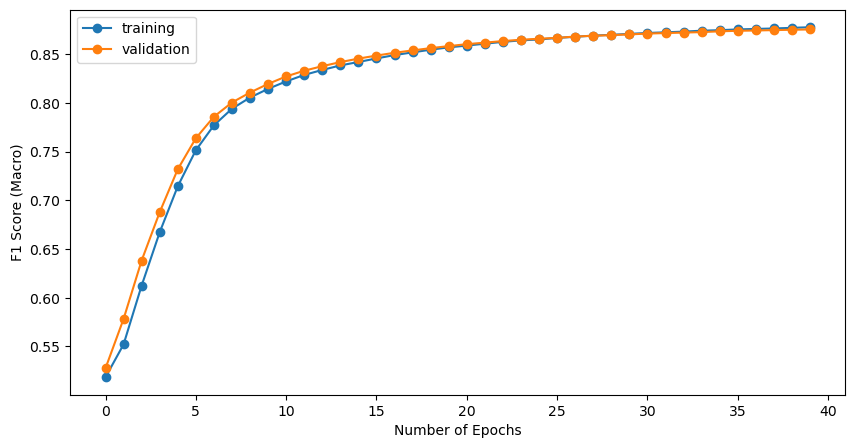

Recall (Macro)
0.8764138375070145
Unseen Class Labels
[ 1  2  3  4  5  6 11 21 22 33 36 38 42]
TSNE spatialisation of Unseen Classes


alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

    antelope       0.92      0.38      0.53       864
grizzly+bear       0.34      0.61      0.44       690
killer+whale       1.00      0.02      0.04       231
      beaver       0.00      0.00      0.00       152
   dalmatian       0.20      0.89      0.33       442
 persian+cat       0.03      0.05      0.04       599
       skunk       0.17      0.27      0.21       157
          ox       0.00      0.00      0.00       588
         fox       0.43      0.18      0.26       540
   chihuahua       0.04      0.02      0.02       448
       otter       0.04      0.04      0.04       592
       zebra       0.00      0.00      0.00       942
         pig       0.14      0.16      0.15       558

    accuracy                           0.21      6803
   macro avg       0.25      0.20      0.16      6803
weighted avg       0.26      0.21      0.18      6803

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.37731481 0.607246

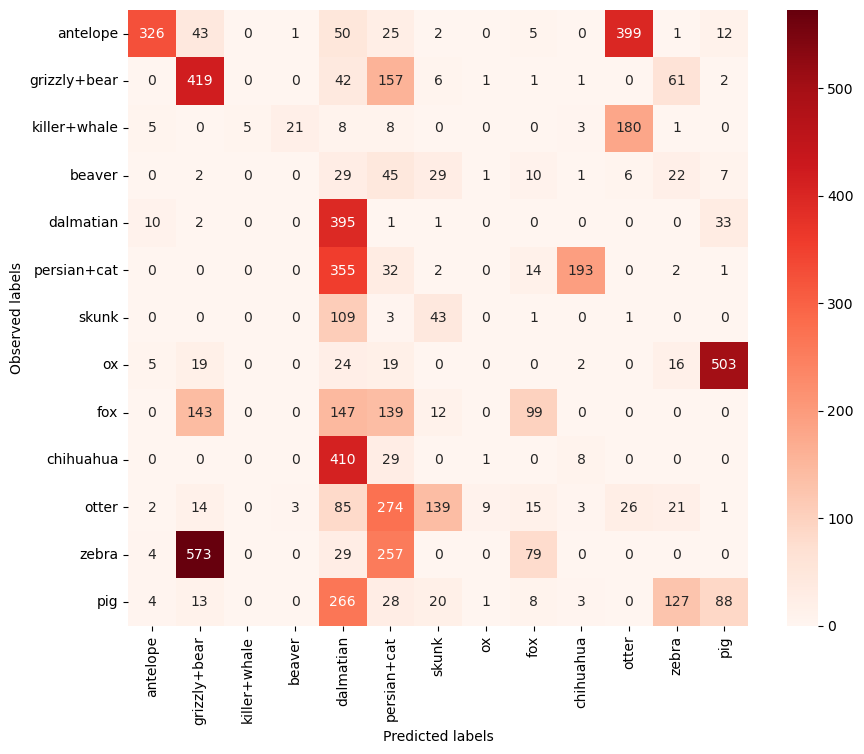

                precision    recall  f1-score   support

  ARTIODACTYLA       0.93      0.42      0.58      2241
     CARNIVORA       0.60      0.96      0.74      3468
PERISSODACTYLA       0.00      0.00      0.00       942
      RODENTIA       0.00      0.00      0.00       152

      accuracy                           0.63      6803
     macro avg       0.38      0.35      0.33      6803
  weighted avg       0.61      0.63      0.57      6803

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.42347166 0.95761246 0.         0.        ]
Top_1_accuracy for UnSeen Validation split 01 -  0.34527103029573114


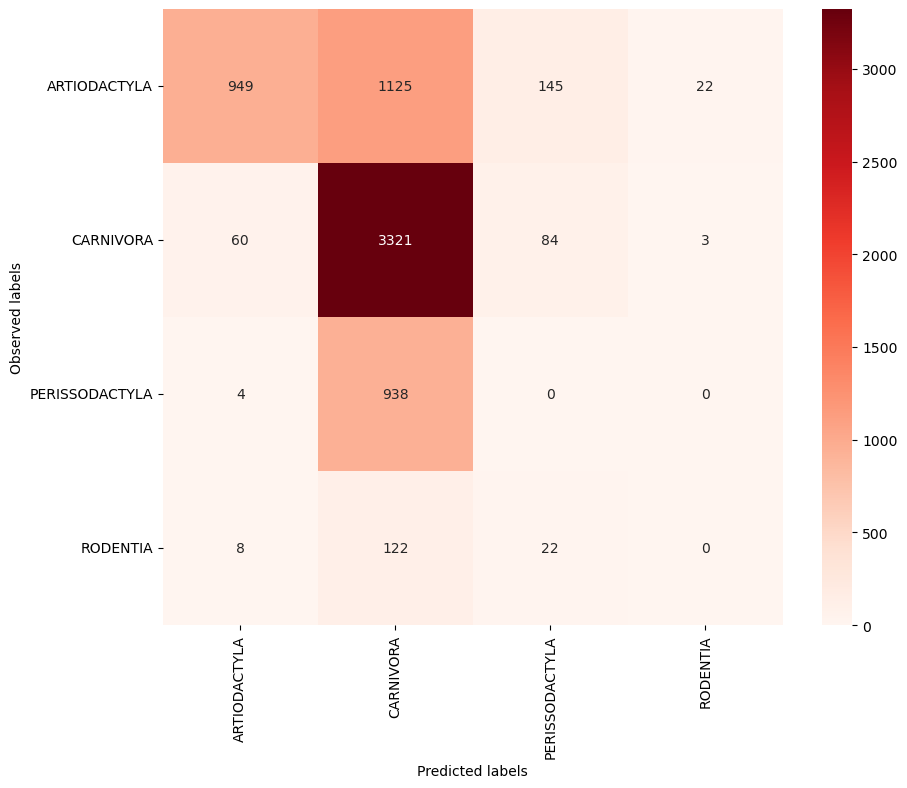

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.33659267090169886 
               0         1
0       antelope  0.849537
1   grizzly+bear  0.817391
2   killer+whale  0.112554
3         beaver  0.019737
4      dalmatian  0.959276
5    persian+cat  0.320534
6          skunk  0.433121
7             ox  0.000000
8            fox  0.350000
9      chihuahua  0.196429
10         otter  0.089527
11         zebra  0.000000
12           pig  0.227599 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.5619830365543458 
               0         1
0       antelope  0.915509
1   grizzly+bear  0.918841
2   killer+whale  0.787879
3         beaver  0.052632
4      dalmatian  0.977376
5    persian+cat  0.933222
6          skunk  0.700637
7             ox  0.006803
8            fox  0.666667
9      chihuahua  0.879464
10         otter  0.180743
11         zebra  0.001062
12           pig  0.284946 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.6341858687095813 
               0         1
0 

In [50]:
Train02 = CZSL(mode = "Train", 
               split = 2, 
               DNN = ProjectionNetwork1, 
               epochs = 40, 
               bs = 8, 
               numunits = 1024, 
               lr = 0.1, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.2, 
               mom = 0, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP2, 
               pred_type = 'Probabilistic', 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

### 8.3 Train Validation Split 03

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.3628                0.5202        0.3364                0.5262     +  2.7721
      2        0.3129                0.5570        0.2893                0.5850     +  2.5810
      3        0.2673                0.6111        0.2479                0.6336     +  2.6260
      4        0.2310                0.6532        0.2158                0.6715     +  2.6164
      5        0.2030                0.6895        0.1909                0.7070     +  2.5568
      6        0.1811                0.7246        0.1712                0.7400     +  2.5789
      7        0.1633                0.7525        0.1553                0.7646     +  2.6581
      8        0.1490                0.7726        0.1421                0.7817     +  2.5028
      9        0.1369                0.7870    

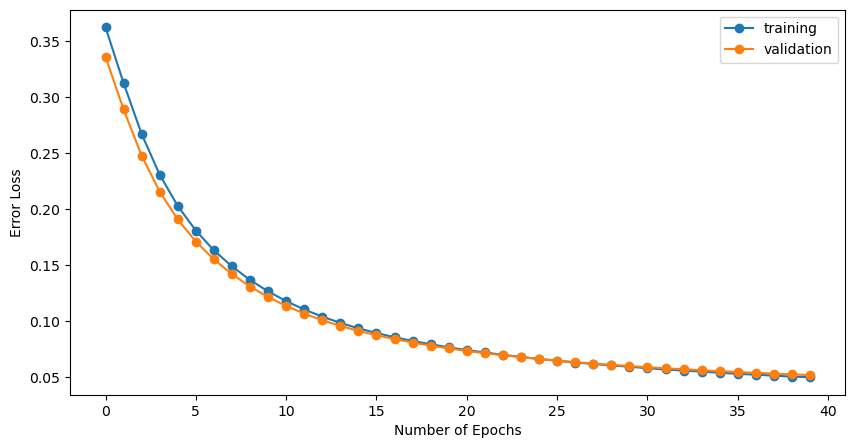

Trianing Recall Macro Curve


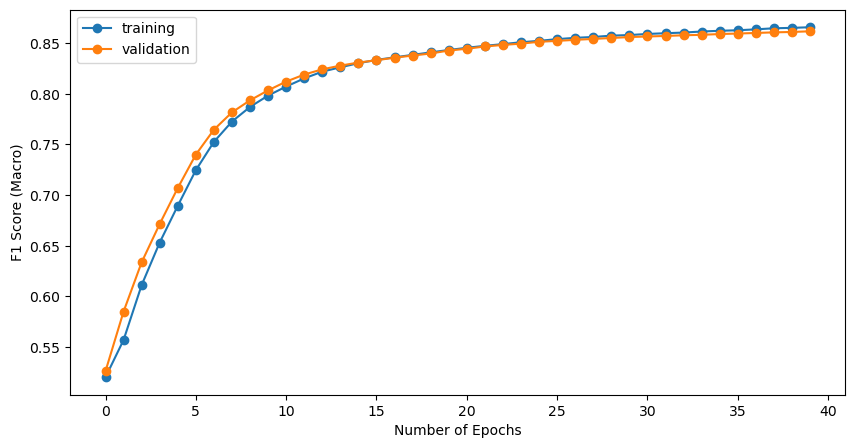

Recall (Macro)
0.8608833248325247
Unseen Class Labels
[10 16 18 25 27 28 29 32 33 35 39 42 48]
TSNE spatialisation of Unseen Classes


alt.LayerChart(...)

alt.LayerChart(...)

                precision    recall  f1-score   support

   siamese+cat       0.04      0.01      0.02       400
         moose       0.20      0.88      0.32       554
humpback+whale       1.00      0.03      0.06       565
    chimpanzee       0.00      0.00      0.00       566
      squirrel       0.06      0.01      0.02       961
    rhinoceros       0.92      0.19      0.31       561
        rabbit       0.09      0.26      0.13       877
          wolf       0.45      0.09      0.15       470
     chihuahua       0.53      0.31      0.39       448
        weasel       0.00      0.00      0.00       222
   giant+panda       0.00      0.00      0.00       692
           pig       0.27      0.18      0.21       558
       raccoon       0.22      0.58      0.32       408

      accuracy                           0.19      7282
     macro avg       0.29      0.19      0.15      7282
  weighted avg       0.28      0.19      0.14      7282

Top_1_accuracy for UnSeen Validation split 01

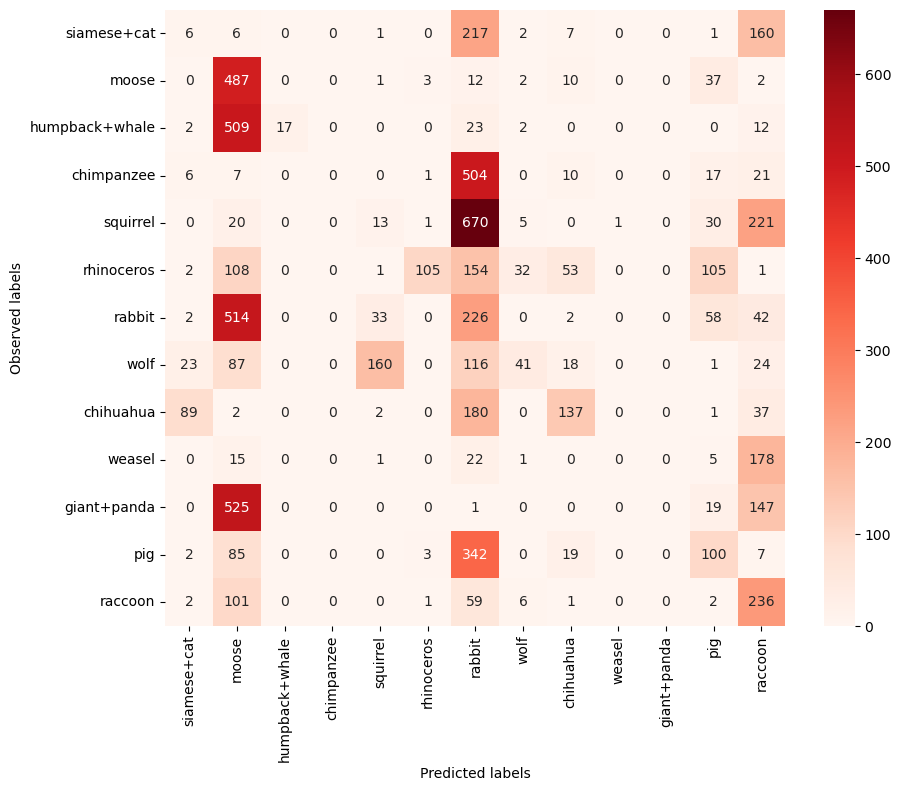

                precision    recall  f1-score   support

  ARTIODACTYLA       0.43      0.74      0.54      1677
     CARNIVORA       0.71      0.42      0.53      2640
    LAGOMORPHA       0.09      0.26      0.13       877
PERISSODACTYLA       0.92      0.19      0.31       561
      PRIMATES       0.00      0.00      0.00       566
      RODENTIA       0.06      0.01      0.02       961

      accuracy                           0.37      7282
     macro avg       0.37      0.27      0.26      7282
  weighted avg       0.45      0.37      0.36      7282

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.73643411 0.42234848 0.25769669 0.18716578 0.         0.01352758]
Top_1_accuracy for UnSeen Validation split 01 -  0.2695287729152423


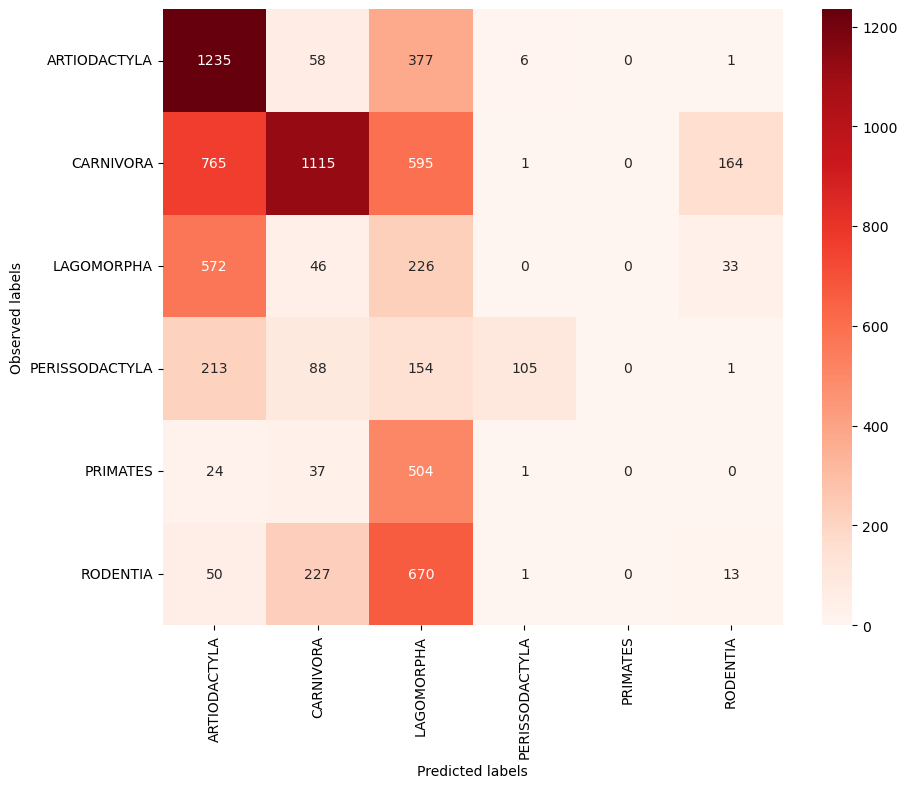

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.3262808823740363 
                 0         1
0      siamese+cat  0.040000
1            moose  0.963899
2   humpback+whale  0.330973
3       chimpanzee  0.000000
4         squirrel  0.209157
5       rhinoceros  0.304813
6           rabbit  0.473204
7             wolf  0.227660
8        chihuahua  0.513393
9           weasel  0.000000
10     giant+panda  0.000000
11             pig  0.347670
12         raccoon  0.830882 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.44253860421804575 
                 0         1
0      siamese+cat  0.132500
1            moose  0.978339
2   humpback+whale  0.446018
3       chimpanzee  0.000000
4         squirrel  0.577523
5       rhinoceros  0.401070
6           rabbit  0.743444
7             wolf  0.434043
8        chihuahua  0.649554
9           weasel  0.022523
10     giant+panda  0.000000
11             pig  0.439068
12         raccoon  0.928922 

 Top- 4  Accuracy per class 
 Top- 4  Accur

In [51]:
Train03 = CZSL(mode = "Train", 
               split = 3, 
               DNN = ProjectionNetwork1, 
               epochs = 40, 
               bs = 8, 
               numunits = 1024, 
               lr = 0.1, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.2, 
               mom = 0, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP3, 
               pred_type = 'Probabilistic', 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

# 9. Hyperoptimisation

In [22]:
import argparse
import optuna
from optuna.integration import SkorchPruningCallback

class ProjectionNetwork_hyper(nn.Module):
    def __init__(self, trial: optuna.Trial):
        super(ProjectionNetwork_hyper, self).__init__()        
        layers = []
        n_layers = trial.suggest_int("n_layers", 1, 3)
        dropout = trial.suggest_float("dropout", 0.1, 0.5)
        input_dim = 2048
        for i in range(n_layers):
            output_dim = trial.suggest_int("n_units_l{}".format(i), 4, 2048, log=True)
            layers.append(nn.Linear(input_dim, output_dim))
            layers.append(nn.Dropout(dropout))
            layers.append(nn.ReLU())
            input_dim = output_dim
        
        layers.append(nn.Linear(input_dim, kg_vec))

        self.model = nn.Sequential(*layers)
        print(self.model)  
        
                        
    def forward(self, x):
        out = self.model(x)
        return out   
    

def objective(trial: optuna.Trial):
    learning_rate = trial.suggest_loguniform('lr', .001, 1)
    bs = trial.suggest_int("batch_size", 4, 64)
    ep = trial.suggest_int("max_epoch", 5, 50)
    mom = trial.suggest_loguniform('optimizer__momentum', .90, .99)
   
       
    hyper_net1 = NeuralNetClassifier(
    ProjectionNetwork_hyper(trial),
    batch_size= bs,
    max_epochs=ep,
    lr=learning_rate,
    criterion = torch.nn.modules.loss.BCEWithLogitsLoss, # to use with Sigmoid 
    optimizer=torch.optim.SGD,
    optimizer__momentum = mom,
    optimizer__weight_decay = 0,
    train_split = ValidSplit(5),
    callbacks=[valid_macro_recall_score,SkorchPruningCallback(trial, 'valid_recall_macro')],
    callbacks__valid_acc=None,
    device='cuda'
    )        
    
    hyper_net2 = NeuralNetClassifier(
    ProjectionNetwork_hyper(trial),
    batch_size= bs,
    max_epochs=ep,
    lr=learning_rate,
    criterion = torch.nn.modules.loss.BCEWithLogitsLoss, # to use with Sigmoid 
    optimizer=torch.optim.SGD,
    optimizer__momentum = mom,
    optimizer__weight_decay = 0,
    train_split = ValidSplit(5),
    callbacks=[valid_macro_recall_score,SkorchPruningCallback(trial, 'valid_recall_macro')],
    callbacks__valid_acc=None,
    device='cuda'
    )        
    
    hyper_net3 = NeuralNetClassifier(
    ProjectionNetwork_hyper(trial),
    batch_size= bs,
    max_epochs=ep,
    lr=learning_rate,
    criterion = torch.nn.modules.loss.BCEWithLogitsLoss, # to use with Sigmoid 
    optimizer=torch.optim.SGD,
    optimizer__momentum = mom,
    optimizer__weight_decay = 0,
    train_split = ValidSplit(5),
    callbacks=[valid_macro_recall_score,SkorchPruningCallback(trial, 'valid_recall_macro')],
    callbacks__valid_acc=None,
    device='cuda'
    )        
    
    #Split 1
    X1= X_train1.astype(np.float32).values
    y1 = y_train1.astype(np.float32).values
    hyper_net1.fit(X1, y1)
    #predict attributes for Unseen classes 
    y_pred_unseen1 = hyper_net1.predict_proba(ValData01.iloc[:,1:2049].astype(np.float32).values)
    
    #assign classes to unseen data by assigning label from closest class using Cosing Distance
    y_pred_unseen_prob1 = []
    for y in y_pred_unseen1:
        y_pred_unseen_prob1.append(y[1])
       
    #limit search space to unseen classes 
    predicatedf_CZSL1 = predicate_df[predicate_df['classes'].isin((ValData01.classes.unique()).tolist())]
    animal_attributes1 = np.array(predicatedf_CZSL1.iloc[:,-kg_vec:])
    animal_attributes_labels1 = predicatedf_CZSL1['labels'].unique()
            
    #assign classes to unseen data by assigning label from closest class using Cosine Distance           
    dist_CZSL1= (1-distance.cdist(y_pred_unseen_prob1, animal_attributes1, 'cosine'))        
    CZSL_label_prediction1 = np.array([np.argmax(output) for output in dist_CZSL1])
    
    #replace predicted labels with unseen class labels 
    CZSL_label_prediction1 = np.select([CZSL_label_prediction1 == 0, CZSL_label_prediction1 == 1, CZSL_label_prediction1 == 2, CZSL_label_prediction1 == 3
          , CZSL_label_prediction1 == 4, CZSL_label_prediction1 == 5, CZSL_label_prediction1 == 6, CZSL_label_prediction1 == 7
          , CZSL_label_prediction1 == 8, CZSL_label_prediction1 == 9, CZSL_label_prediction1 == 10, CZSL_label_prediction1 == 11
          , CZSL_label_prediction1 == 12], [animal_attributes_labels1[0], animal_attributes_labels1[1], animal_attributes_labels1[2]
          , animal_attributes_labels1[3], animal_attributes_labels1[4], animal_attributes_labels1[5]
          , animal_attributes_labels1[6], animal_attributes_labels1[7], animal_attributes_labels1[8], animal_attributes_labels1[9]
          , animal_attributes_labels1[10], animal_attributes_labels1[11], animal_attributes_labels1[12]], CZSL_label_prediction1)
        
    recall_score1 = recall_score(ValData01['labels'], CZSL_label_prediction1, average = 'macro')
    
    #Split 2
    X2= X_train2.astype(np.float32).values
    y2 = y_train2.astype(np.float32).values
    hyper_net2.fit(X2, y2)
    #predict attributes for Unseen classes 
    y_pred_unseen2 = hyper_net2.predict_proba(ValData02.iloc[:,1:2049].astype(np.float32).values)
    
    #assign classes to unseen data by assigning label from closest class using Cosing Distance
    y_pred_unseen_prob2 = []
    for y in y_pred_unseen2:
        y_pred_unseen_prob2.append(y[1])
       
    #limit search space to unseen classes 
    predicatedf_CZSL2 = predicate_df[predicate_df['classes'].isin((ValData02.classes.unique()).tolist())]
    animal_attributes2 = np.array(predicatedf_CZSL2.iloc[:,-kg_vec:])
    animal_attributes_labels2 = predicatedf_CZSL2['labels'].unique()
            
    #assign classes to unseen data by assigning label from closest class using Cosing Distance           
    dist_CZSL2= (1-distance.cdist(y_pred_unseen_prob2, animal_attributes2, 'cosine'))        
    CZSL_label_prediction2 = np.array([np.argmax(output) for output in dist_CZSL2])
    
    #replace predicted labels with unseen class labels 
    CZSL_label_prediction2 = np.select([CZSL_label_prediction2 == 0, CZSL_label_prediction2 == 1, CZSL_label_prediction2 == 2, CZSL_label_prediction2 == 3
          , CZSL_label_prediction2 == 4, CZSL_label_prediction2 == 5, CZSL_label_prediction2 == 6, CZSL_label_prediction2 == 7
          , CZSL_label_prediction2 == 8, CZSL_label_prediction2 == 9, CZSL_label_prediction2 == 10, CZSL_label_prediction2 == 11
          , CZSL_label_prediction2 == 12], [animal_attributes_labels2[0], animal_attributes_labels2[1], animal_attributes_labels2[2]
          , animal_attributes_labels2[3], animal_attributes_labels2[4], animal_attributes_labels2[5]
          , animal_attributes_labels2[6], animal_attributes_labels2[7], animal_attributes_labels2[8], animal_attributes_labels2[9]
          , animal_attributes_labels2[10], animal_attributes_labels2[11], animal_attributes_labels2[12]], CZSL_label_prediction2)
        
    recall_score2 = recall_score(ValData02['labels'], CZSL_label_prediction2, average = 'macro')
   
    #Split 3
    X3= X_train3.astype(np.float32).values
    y3 = y_train3.astype(np.float32).values
    hyper_net3.fit(X3, y3)
    #predict attributes for Unseen classes 
    y_pred_unseen3 = hyper_net3.predict_proba(ValData03.iloc[:,1:2049].astype(np.float32).values)
    
    #assign classes to unseen data by assigning label from closest class using Cosing Distance
    y_pred_unseen_prob3 = []
    for y in y_pred_unseen3:
        y_pred_unseen_prob3.append(y[1])
       
    #limit search space to unseen classes 
    predicatedf_CZSL3 = predicate_df[predicate_df['classes'].isin((ValData03.classes.unique()).tolist())]
    animal_attributes3 = np.array(predicatedf_CZSL3.iloc[:,-kg_vec:])
    animal_attributes_labels3 = predicatedf_CZSL3['labels'].unique()
            
    #assign classes to unseen data by assigning label from closest class using Cosing Distance           
    dist_CZSL3= (1-distance.cdist(y_pred_unseen_prob3, animal_attributes3, 'cosine'))        
    CZSL_label_prediction3 = np.array([np.argmax(output) for output in dist_CZSL3])
    
    #replace predicted labels with unseen class labels 
    CZSL_label_prediction3 = np.select([CZSL_label_prediction3 == 0, CZSL_label_prediction3 == 1, CZSL_label_prediction3 == 2, CZSL_label_prediction3 == 3
          , CZSL_label_prediction3 == 4, CZSL_label_prediction3 == 5, CZSL_label_prediction3 == 6, CZSL_label_prediction3 == 7
          , CZSL_label_prediction3 == 8, CZSL_label_prediction3 == 9, CZSL_label_prediction3 == 10, CZSL_label_prediction3 == 11
          , CZSL_label_prediction3 == 12], [animal_attributes_labels3[0], animal_attributes_labels3[1], animal_attributes_labels3[2]
          , animal_attributes_labels3[3], animal_attributes_labels3[4], animal_attributes_labels3[5]
          , animal_attributes_labels3[6], animal_attributes_labels3[7], animal_attributes_labels3[8], animal_attributes_labels3[9]
          , animal_attributes_labels3[10], animal_attributes_labels3[11], animal_attributes_labels3[12]], CZSL_label_prediction3)
        
    recall_score3 = recall_score(ValData03['labels'], CZSL_label_prediction3, average = 'macro')
    
    results = [recall_score1,recall_score2,recall_score3]
    print(results)
    #hyper_net.set_params(verbose=0)

    return np.mean(results)

In [23]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="DNN with KG.")
    parser.add_argument(
        "--pruning",
        "-p",
        action="store_true",
        help="Activate the pruning feature. `MedianPruner` stops unpromising "
        "trials at the early stages of training.",
    )
    args, unknown = parser.parse_known_args()

    pruner = optuna.pruners.MedianPruner() if args.pruning else optuna.pruners.NopPruner()

    study = optuna.create_study(direction="maximize", pruner=pruner)
    study.optimize(objective, n_trials=100, timeout=1000)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-12-08 20:52:04,763] A new study created in memory with name: no-name-51c1a20e-2e63-428b-9cfe-1bf09af13a22


Sequential(
  (0): Linear(in_features=2048, out_features=6, bias=True)
  (1): Dropout(p=0.2820683238619528, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=6, out_features=107, bias=True)
  (4): Dropout(p=0.2820683238619528, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=107, out_features=300, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=6, bias=True)
  (1): Dropout(p=0.2820683238619528, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=6, out_features=107, bias=True)
  (4): Dropout(p=0.2820683238619528, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=107, out_features=300, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=6, bias=True)
  (1): Dropout(p=0.2820683238619528, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=6, out_features=107, bias=True)
  (4): Dropout(p=0.2820683238619528, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=107, out_features=300, bias=True)
)
  epoch    train_loss    valid_

     34        0.5086        0.4832                0.5226  0.5522
     35        0.5070        0.4816                0.5233  0.6408
     36        0.5063        0.4804                0.5238  0.5967
     37        0.5050        0.4794                0.5245  0.5945
     38        0.5033        0.4780                0.5251  0.5902
     39        0.5022        0.4765                0.5258  0.6053
     40        0.5019        0.4751                0.5266  0.6295
     41        0.5007        0.4745                0.5275  0.6464
     42        0.4999        0.4731                0.5283  0.6086
     43        0.4993        0.4721                0.5292  0.5917
     44        0.4978        0.4710                0.5298  0.6006
     45        0.4960        0.4696                0.5306  0.6111
  epoch    train_loss    valid_loss    valid_recall_macro     dur
-------  ------------  ------------  --------------------  ------
      1        0.6903        0.6857                0.5215  0.6326
      2   

[I 2022-12-08 20:53:46,113] Trial 0 finished with value: 0.1601255428359418 and parameters: {'lr': 0.0027002692218068697, 'batch_size': 57, 'max_epoch': 45, 'optimizer__momentum': 0.9047838881939125, 'n_layers': 2, 'dropout': 0.2820683238619528, 'n_units_l0': 6, 'n_units_l1': 107}. Best is trial 0 with value: 0.1601255428359418.


[0.1493341157604902, 0.12806213105678893, 0.2029803816905462]
Sequential(
  (0): Linear(in_features=2048, out_features=317, bias=True)
  (1): Dropout(p=0.2491064556407755, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=317, out_features=1044, bias=True)
  (4): Dropout(p=0.2491064556407755, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=1044, out_features=300, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=317, bias=True)
  (1): Dropout(p=0.2491064556407755, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=317, out_features=1044, bias=True)
  (4): Dropout(p=0.2491064556407755, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=1044, out_features=300, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=317, bias=True)
  (1): Dropout(p=0.2491064556407755, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=317, out_features=1044, bias=True)
  (4): Dropout(p=0.2491064556407755, inplace=False)
  (5): ReLU()
  (6): Linear(

     20        0.0071        0.0579                0.9571  1.2074
     21        0.0063        0.0617                0.9569  1.2180
     22        0.0056        0.0674                0.9559  1.2855
     23        0.0052        0.0605                0.9580  1.2328
     24        0.0050        0.0629                0.9577  1.2416
     25        0.0048        0.0671                0.9557  1.1295
     26        0.0045        0.0646                0.9576  1.1659
     27        0.0043        0.0683                0.9560  0.9183
     28        0.0043        0.0681                0.9563  0.9334
     29        0.0045        0.0706                0.9557  0.9180
     30        0.0040        0.0666                0.9577  0.9246
     31        0.0045        0.0685                0.9564  0.9046
     32        0.0036        0.0639                0.9581  1.0082


[I 2022-12-08 20:55:44,840] Trial 1 finished with value: 0.3018647403759818 and parameters: {'lr': 0.011146525928508101, 'batch_size': 23, 'max_epoch': 32, 'optimizer__momentum': 0.979313101159001, 'n_layers': 2, 'dropout': 0.2491064556407755, 'n_units_l0': 317, 'n_units_l1': 1044}. Best is trial 1 with value: 0.3018647403759818.


[0.21364609878733645, 0.33127814536528055, 0.36066997697532854]
Sequential(
  (0): Linear(in_features=2048, out_features=194, bias=True)
  (1): Dropout(p=0.10795318154808604, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=194, out_features=300, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=194, bias=True)
  (1): Dropout(p=0.10795318154808604, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=194, out_features=300, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=194, bias=True)
  (1): Dropout(p=0.10795318154808604, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=194, out_features=300, bias=True)
)
  epoch    train_loss    valid_loss    valid_recall_macro     dur
-------  ------------  ------------  --------------------  ------
      1        0.6222        0.5350                0.4991  0.8410
      2        0.5185        0.4966                0.5410  0.8792
      3        0.4906        0.4702                0.5691  0.9675


     32        0.1548        0.1491                0.8901  0.7728
     33        0.1518        0.1463                0.8922  0.9543
     34        0.1486        0.1436                0.8938  0.9503
     35        0.1460        0.1410                0.8955  0.9813
     36        0.1433        0.1386                0.8970  0.9996
     37        0.1409        0.1363                0.8982  0.9814
     38        0.1382        0.1340                0.8997  0.7451
     39        0.1357        0.1319                0.9010  0.7358
     40        0.1335        0.1299                0.9021  0.7310
     41        0.1316        0.1279                0.9033  0.7444
     42        0.1294        0.1260                0.9042  0.7506
     43        0.1275        0.1242                0.9053  0.8693
     44        0.1257        0.1225                0.9063  0.8000
     45        0.1237        0.1208                0.9074  1.0770
     46        0.1221        0.1193                0.9084  0.9264
     47   

[I 2022-12-08 20:58:21,020] Trial 2 finished with value: 0.2954749057491229 and parameters: {'lr': 0.0021164989445148865, 'batch_size': 24, 'max_epoch': 48, 'optimizer__momentum': 0.9053389990829586, 'n_layers': 1, 'dropout': 0.10795318154808604, 'n_units_l0': 194}. Best is trial 1 with value: 0.3018647403759818.


[0.17470476316780445, 0.33658816753945153, 0.37513178654011275]
Sequential(
  (0): Linear(in_features=2048, out_features=10, bias=True)
  (1): Dropout(p=0.4858151777148457, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=10, out_features=10, bias=True)
  (4): Dropout(p=0.4858151777148457, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=10, out_features=8, bias=True)
  (7): Dropout(p=0.4858151777148457, inplace=False)
  (8): ReLU()
  (9): Linear(in_features=8, out_features=300, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=10, bias=True)
  (1): Dropout(p=0.4858151777148457, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=10, out_features=10, bias=True)
  (4): Dropout(p=0.4858151777148457, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=10, out_features=8, bias=True)
  (7): Dropout(p=0.4858151777148457, inplace=False)
  (8): ReLU()
  (9): Linear(in_features=8, out_features=300, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, ou

      4        0.6932        0.6917                0.4967  0.4965
      5        0.6913        0.6899                0.4956  0.4967
      6        0.6894        0.6882                0.4926  0.4995
      7        0.6877        0.6865                0.4895  0.5162
      8        0.6860        0.6848                0.4928  0.4939
      9        0.6843        0.6832                0.4992  0.4983
     10        0.6827        0.6815                0.5009  0.5033
     11        0.6810        0.6799                0.5021  0.5001
     12        0.6794        0.6783                0.5068  0.5131
     13        0.6778        0.6767                0.5092  0.5040
     14        0.6762        0.6750                0.5122  0.4977
     15        0.6746        0.6734                0.5100  0.5057
     16        0.6730        0.6718                0.5131  0.5244
     17        0.6714        0.6702                0.5086  0.5653
     18        0.6699        0.6685                0.5146  0.5208
     19   

[I 2022-12-08 20:59:38,446] Trial 3 finished with value: 0.07692307692307693 and parameters: {'lr': 0.003334935928122922, 'batch_size': 63, 'max_epoch': 35, 'optimizer__momentum': 0.9097012182482019, 'n_layers': 3, 'dropout': 0.4858151777148457, 'n_units_l0': 10, 'n_units_l1': 10, 'n_units_l2': 8}. Best is trial 1 with value: 0.3018647403759818.


[0.07692307692307693, 0.07692307692307693, 0.07692307692307693]
Sequential(
  (0): Linear(in_features=2048, out_features=8, bias=True)
  (1): Dropout(p=0.2869040238004392, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=8, out_features=48, bias=True)
  (4): Dropout(p=0.2869040238004392, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=48, out_features=300, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=8, bias=True)
  (1): Dropout(p=0.2869040238004392, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=8, out_features=48, bias=True)
  (4): Dropout(p=0.2869040238004392, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=48, out_features=300, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=8, bias=True)
  (1): Dropout(p=0.2869040238004392, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=8, out_features=48, bias=True)
  (4): Dropout(p=0.2869040238004392, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=48, out_

[I 2022-12-08 21:00:20,889] Trial 4 finished with value: 0.13307903051642278 and parameters: {'lr': 0.002490197822357935, 'batch_size': 17, 'max_epoch': 8, 'optimizer__momentum': 0.9536810304543848, 'n_layers': 2, 'dropout': 0.2869040238004392, 'n_units_l0': 8, 'n_units_l1': 48}. Best is trial 1 with value: 0.3018647403759818.


[0.12979796178069086, 0.0918836640610834, 0.1775554657074941]
Sequential(
  (0): Linear(in_features=2048, out_features=78, bias=True)
  (1): Dropout(p=0.31868021549727776, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=78, out_features=1679, bias=True)
  (4): Dropout(p=0.31868021549727776, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=1679, out_features=300, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=78, bias=True)
  (1): Dropout(p=0.31868021549727776, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=78, out_features=1679, bias=True)
  (4): Dropout(p=0.31868021549727776, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=1679, out_features=300, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=78, bias=True)
  (1): Dropout(p=0.31868021549727776, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=78, out_features=1679, bias=True)
  (4): Dropout(p=0.31868021549727776, inplace=False)
  (5): ReLU()
  (6): Linear(

[I 2022-12-08 21:01:02,110] Trial 5 finished with value: 0.3202937187091192 and parameters: {'lr': 0.12290408599069613, 'batch_size': 46, 'max_epoch': 16, 'optimizer__momentum': 0.9102009362997737, 'n_layers': 2, 'dropout': 0.31868021549727776, 'n_units_l0': 78, 'n_units_l1': 1679}. Best is trial 5 with value: 0.3202937187091192.


[0.22908771388071664, 0.34424341048199697, 0.3875500317646439]
Sequential(
  (0): Linear(in_features=2048, out_features=6, bias=True)
  (1): Dropout(p=0.3371806728113616, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=6, out_features=596, bias=True)
  (4): Dropout(p=0.3371806728113616, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=596, out_features=300, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=6, bias=True)
  (1): Dropout(p=0.3371806728113616, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=6, out_features=596, bias=True)
  (4): Dropout(p=0.3371806728113616, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=596, out_features=300, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=6, bias=True)
  (1): Dropout(p=0.3371806728113616, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=6, out_features=596, bias=True)
  (4): Dropout(p=0.3371806728113616, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=596,

     22        0.5273        0.5279                0.4933  2.2952
     23        0.5273        0.5279                0.4933  2.0208
     24        0.5273        0.5279                0.4933  2.1170
     25        0.5273        0.5279                0.4933  1.9817
     26        0.5273        0.5279                0.4933  2.7214
     27        0.5273        0.5279                0.4933  2.6913
     28        0.5273        0.5279                0.4933  2.6137
     29        0.5273        0.5279                0.4933  2.9607
     30        0.5273        0.5279                0.4933  2.3645


[I 2022-12-08 21:04:50,435] Trial 6 finished with value: 0.07692307692307693 and parameters: {'lr': 0.31956716582067657, 'batch_size': 9, 'max_epoch': 30, 'optimizer__momentum': 0.9856582682841508, 'n_layers': 2, 'dropout': 0.3371806728113616, 'n_units_l0': 6, 'n_units_l1': 596}. Best is trial 5 with value: 0.3202937187091192.


[0.07692307692307693, 0.07692307692307693, 0.07692307692307693]
Sequential(
  (0): Linear(in_features=2048, out_features=236, bias=True)
  (1): Dropout(p=0.4629543172300534, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=236, out_features=300, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=236, bias=True)
  (1): Dropout(p=0.4629543172300534, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=236, out_features=300, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=236, bias=True)
  (1): Dropout(p=0.4629543172300534, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=236, out_features=300, bias=True)
)
  epoch    train_loss    valid_loss    valid_recall_macro     dur
-------  ------------  ------------  --------------------  ------
      1        0.2977        0.1214                0.9090  0.9163
      2        0.1258        0.0701                0.9404  0.9076
      3        0.0904        0.0551                0.9481  0.9228
   

      7        0.0498        0.0484                0.9549  0.6765
      8        0.0464        0.0510                0.9534  0.6576
      9        0.0425        0.0498                0.9544  0.6454
     10        0.0392        0.0494                0.9544  0.6728
     11        0.0377        0.0492                0.9548  0.6684
     12        0.0340        0.0492                0.9552  0.6598
     13        0.0328        0.0503                0.9533  0.6552
     14        0.0307        0.0493                0.9545  0.6576
     15        0.0286        0.0484                0.9565  0.6525
     16        0.0282        0.0507                0.9543  0.6729
     17        0.0266        0.0519                0.9544  0.6898
     18        0.0243        0.0518                0.9544  0.6920
     19        0.0240        0.0502                0.9556  0.6862
     20        0.0228        0.0517                0.9556  0.6789
     21        0.0228        0.0512                0.9549  0.7535
     22   

[I 2022-12-08 21:06:44,240] Trial 7 finished with value: 0.30767391330959515 and parameters: {'lr': 0.10598038145456111, 'batch_size': 28, 'max_epoch': 42, 'optimizer__momentum': 0.9214759291464131, 'n_layers': 1, 'dropout': 0.4629543172300534, 'n_units_l0': 236}. Best is trial 5 with value: 0.3202937187091192.


[0.20644630810618367, 0.3278678589980569, 0.3887075728245449]
Sequential(
  (0): Linear(in_features=2048, out_features=33, bias=True)
  (1): Dropout(p=0.4608086868487504, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=33, out_features=300, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=33, bias=True)
  (1): Dropout(p=0.4608086868487504, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=33, out_features=300, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=33, bias=True)
  (1): Dropout(p=0.4608086868487504, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=33, out_features=300, bias=True)
)
  epoch    train_loss    valid_loss    valid_recall_macro     dur
-------  ------------  ------------  --------------------  ------
      1        0.4616        0.3050                0.7409  1.4385
      2        0.3919        0.2876                0.7545  1.4775
      3        0.3732        0.2630                0.7592  1.4964
      4    

[I 2022-12-08 21:07:38,752] Trial 8 finished with value: 0.22295409785179 and parameters: {'lr': 0.04904129532811306, 'batch_size': 11, 'max_epoch': 10, 'optimizer__momentum': 0.9682431241792689, 'n_layers': 1, 'dropout': 0.4608086868487504, 'n_units_l0': 33}. Best is trial 5 with value: 0.3202937187091192.


[0.07557163161176048, 0.30406540203704185, 0.28922525990656767]
Sequential(
  (0): Linear(in_features=2048, out_features=1864, bias=True)
  (1): Dropout(p=0.488190811219553, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=1864, out_features=15, bias=True)
  (4): Dropout(p=0.488190811219553, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=15, out_features=300, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=1864, bias=True)
  (1): Dropout(p=0.488190811219553, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=1864, out_features=15, bias=True)
  (4): Dropout(p=0.488190811219553, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=15, out_features=300, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=1864, bias=True)
  (1): Dropout(p=0.488190811219553, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=1864, out_features=15, bias=True)
  (4): Dropout(p=0.488190811219553, inplace=False)
  (5): ReLU()
  (6): Linear(in_featu

     14        0.5271        0.5277                0.4933  1.4920
     15        0.5271        0.5277                0.4933  1.4801
     16        0.5271        0.5277                0.4933  1.4959
     17        0.5271        0.5277                0.4933  1.4970
     18        0.5271        0.5277                0.4933  1.4983
     19        0.5271        0.5277                0.4933  1.4968
     20        0.5271        0.5277                0.4933  1.5027
     21        0.5271        0.5277                0.4933  1.4998
     22        0.5271        0.5277                0.4933  1.5115
     23        0.5271        0.5277                0.4933  1.6933
     24        0.5271        0.5277                0.4933  1.8509
     25        0.5271        0.5277                0.4933  1.7921
     26        0.5271        0.5277                0.4933  1.7908
     27        0.5271        0.5277                0.4933  1.7903
     28        0.5271        0.5277                0.4933  1.7686
     29   

[I 2022-12-08 21:10:47,134] Trial 9 finished with value: 0.07692307692307693 and parameters: {'lr': 0.46288468342923955, 'batch_size': 16, 'max_epoch': 34, 'optimizer__momentum': 0.9799485490762311, 'n_layers': 2, 'dropout': 0.488190811219553, 'n_units_l0': 1864, 'n_units_l1': 15}. Best is trial 5 with value: 0.3202937187091192.


[0.07692307692307693, 0.07692307692307693, 0.07692307692307693]
Number of finished trials: 10
Best trial:
  Value: 0.3202937187091192
  Params: 
    lr: 0.12290408599069613
    batch_size: 46
    max_epoch: 16
    optimizer__momentum: 0.9102009362997737
    n_layers: 2
    dropout: 0.31868021549727776
    n_units_l0: 78
    n_units_l1: 1679


# 10. CZSL on Unseen Test Set using Hyperoptiimsation parameters

In [24]:
class ProjectionNetwork2(nn.Module):
    def __init__(self, num_units, non_linear,dropout):
        super(ProjectionNetwork2, self).__init__()        
        self.fc1 = nn.Linear(2048, 78)  
        self.fc2 = nn.Linear(78, 1679) 
        self.fc3 = nn.Linear(1679, kg_vec) 
        self.nonlinear = non_linear  
        self.dropout = nn.Dropout(dropout)
                        
    def forward(self, x):
        out = self.fc1(x)
        out = self.dropout(out)
        out = self.nonlinear(out)
        out = self.fc2(out)
        out = self.dropout(out)
        out = self.nonlinear(out)
        out = self.fc3(out)
        return out   

In [28]:
Train01 = CZSL(mode = "Train", 
               split = 1, 
               DNN = ProjectionNetwork2, 
               epochs = 16, 
               bs = 46, 
               numunits = 0, 
               lr = 0.12290408599069613, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.31868021549727776 
               mom = 0.9102009362997737, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP1, 
               pred_type = 'Probabilistic', 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

SyntaxError: invalid syntax (1603233370.py, line 10)

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.5269                0.4971        0.5194                0.4920     +  0.7911
      2        0.5069                0.5124        0.4859                0.5253     +  0.5854
      3        0.4744                0.5414        0.4506                0.5759     +  0.6340
      4        0.4437                0.5768        0.4187                0.6204     +  0.7391
      5        0.4148                0.6088        0.3889                0.6640     +  0.6390
      6        0.3882                0.6410        0.3639                0.6965     +  0.6295
      7        0.3656                0.6680        0.3452                0.7194     +  0.7125
      8        0.3473                0.6876        0.3302                0.7436     +  0.6112
      9        0.3321                0.7028    

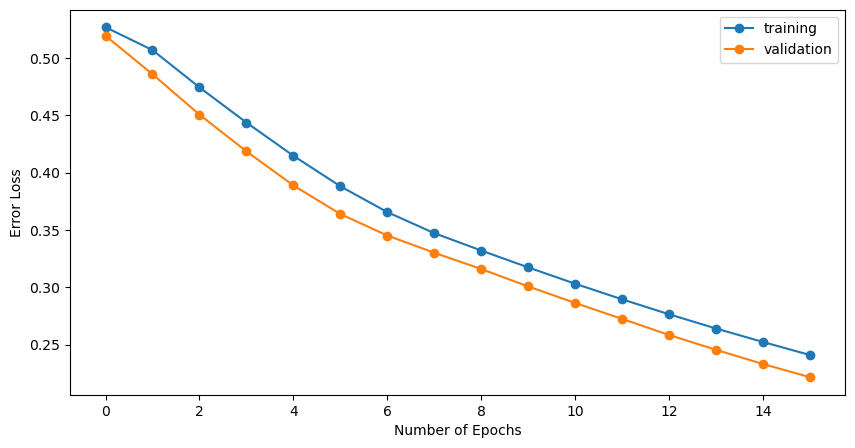

Trianing Recall Macro Curve


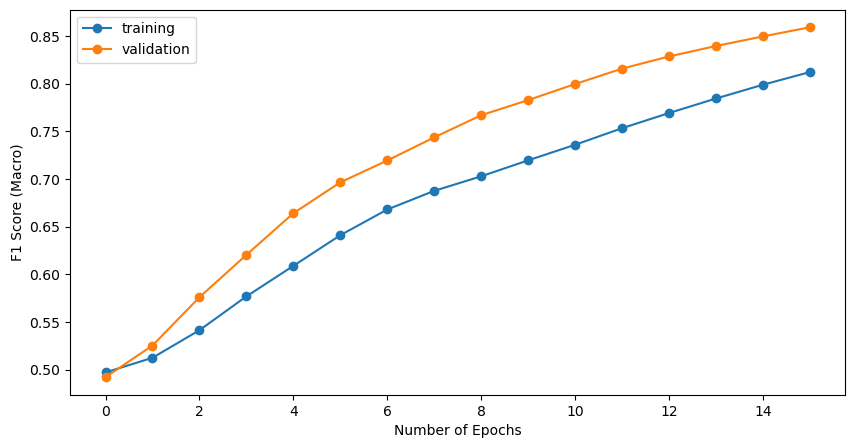

Recall (Macro)
0.8616954436945654
Unseen Class Labels
[ 1  2  3  4  5  6 11 21 22 33 36 38 42]
TSNE spatialisation of Unseen Classes


alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

    antelope       0.45      0.95      0.62       864
grizzly+bear       0.76      0.83      0.79       690
killer+whale       0.00      0.00      0.00       231
      beaver       0.06      0.10      0.07       152
   dalmatian       0.02      0.02      0.02       442
 persian+cat       0.00      0.00      0.00       599
       skunk       0.22      0.76      0.34       157
          ox       0.25      0.00      0.00       588
         fox       0.18      0.02      0.04       540
   chihuahua       0.24      0.57      0.34       448
       otter       0.29      0.29      0.29       592
       zebra       0.67      0.05      0.10       942
         pig       0.23      0.53      0.32       558

    accuracy                           0.34      6803
   macro avg       0.26      0.32      0.23      6803
weighted avg       0.33      0.34      0.26      6803

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.95138889 0.827536

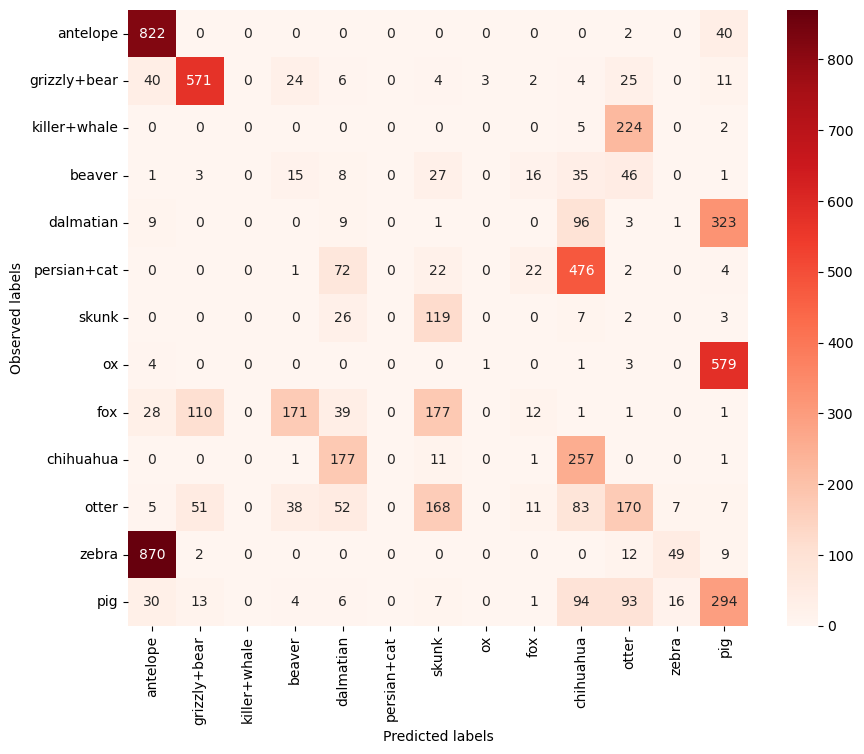

                precision    recall  f1-score   support

  ARTIODACTYLA       0.57      0.79      0.67      2241
     CARNIVORA       0.82      0.80      0.81      3468
PERISSODACTYLA       0.67      0.05      0.10       942
      RODENTIA       0.06      0.10      0.07       152

      accuracy                           0.68      6803
     macro avg       0.53      0.44      0.41      6803
  weighted avg       0.70      0.68      0.65      6803

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.79071843 0.80449827 0.05201699 0.09868421]
Top_1_accuracy for UnSeen Validation split 01 -  0.43647947370829


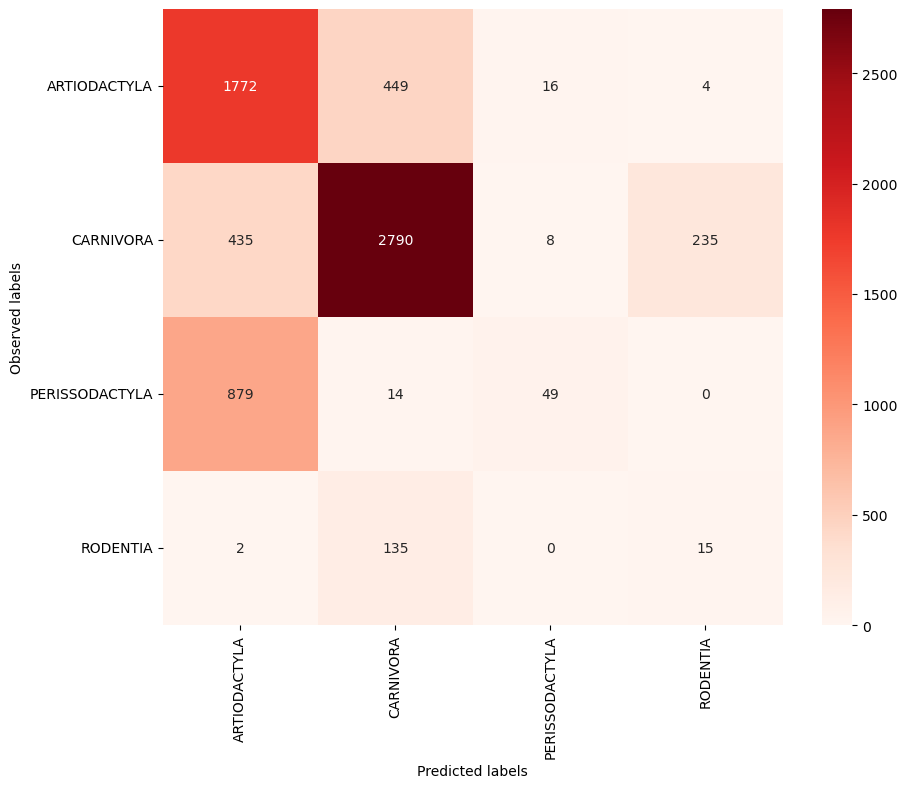

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.5378826032980321 
               0         1
0       antelope  0.991898
1   grizzly+bear  0.926087
2   killer+whale  0.839827
3         beaver  0.131579
4      dalmatian  0.199095
5    persian+cat  0.000000
6          skunk  0.802548
7             ox  0.736395
8            fox  0.155556
9      chihuahua  0.975446
10         otter  0.437500
11         zebra  0.212314
12           pig  0.584229 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.7034863029611832 
               0         1
0       antelope  0.995370
1   grizzly+bear  0.944928
2   killer+whale  0.952381
3         beaver  0.407895
4      dalmatian  0.529412
5    persian+cat  0.570952
6          skunk  0.904459
7             ox  0.828231
8            fox  0.381481
9      chihuahua  0.988839
10         otter  0.576014
11         zebra  0.378981
12           pig  0.686380 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.8135148065773943 
               0         1
0  

In [29]:
Train02 = CZSL(mode = "Train", 
               split = 2, 
               DNN = ProjectionNetwork2, 
               epochs = 16, 
               bs = 46, 
               numunits = 0, 
               lr = 0.12290408599069613, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.31868021549727776,
               mom = 0.9102009362997737, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP2, 
               pred_type = 'Probabilistic', 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.5316                0.5012        0.5220                0.4937     +  0.8595
      2        0.5110                0.5204        0.4859                0.5417     +  0.5521
      3        0.4736                0.5593        0.4393                0.5920     +  0.6885
      4        0.4360                0.5933        0.4048                0.6396     +  0.7769
      5        0.4053                0.6238        0.3766                0.6805     +  0.8170
      6        0.3792                0.6546        0.3539                0.7186     +  0.5419
      7        0.3583                0.6780        0.3369                0.7425     +  0.6532
      8        0.3415                0.6983        0.3233                0.7613     +  0.7341
      9        0.3273                0.7162    

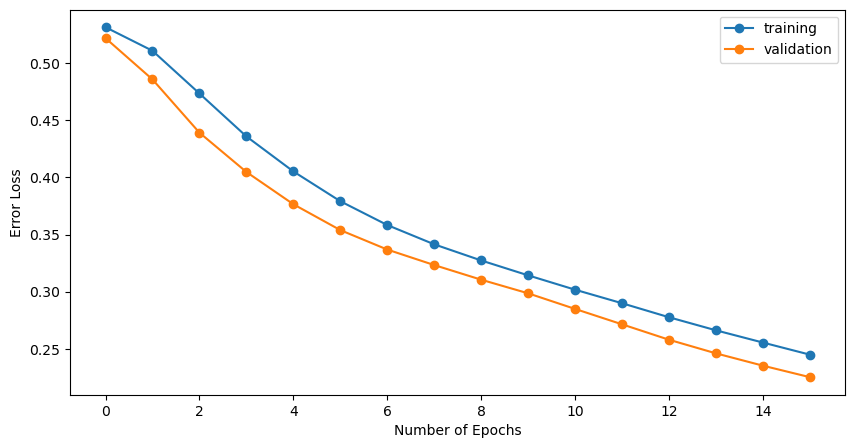

Trianing Recall Macro Curve


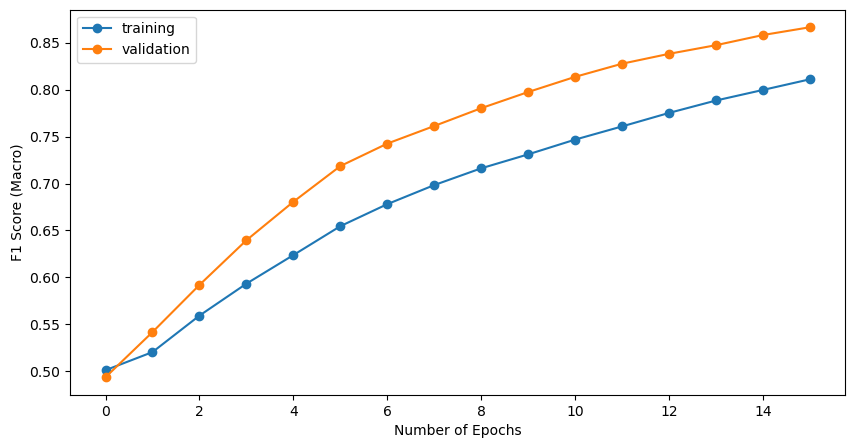

Recall (Macro)
0.8643258581301487
Unseen Class Labels
[10 16 18 25 27 28 29 32 33 35 39 42 48]
TSNE spatialisation of Unseen Classes


alt.LayerChart(...)

alt.LayerChart(...)

                precision    recall  f1-score   support

   siamese+cat       0.23      0.89      0.36       400
         moose       0.18      0.56      0.28       554
humpback+whale       0.96      0.38      0.54       565
    chimpanzee       0.87      0.02      0.04       566
      squirrel       0.30      0.22      0.25       961
    rhinoceros       0.37      0.40      0.39       561
        rabbit       0.50      0.29      0.36       877
          wolf       0.43      0.32      0.37       470
     chihuahua       0.12      0.17      0.14       448
        weasel       0.00      0.00      0.00       222
   giant+panda       0.30      0.03      0.05       692
           pig       0.37      0.64      0.47       558
       raccoon       0.00      0.00      0.00       408

      accuracy                           0.30      7282
     macro avg       0.36      0.30      0.25      7282
  weighted avg       0.39      0.30      0.27      7282

Top_1_accuracy for UnSeen Validation split 01

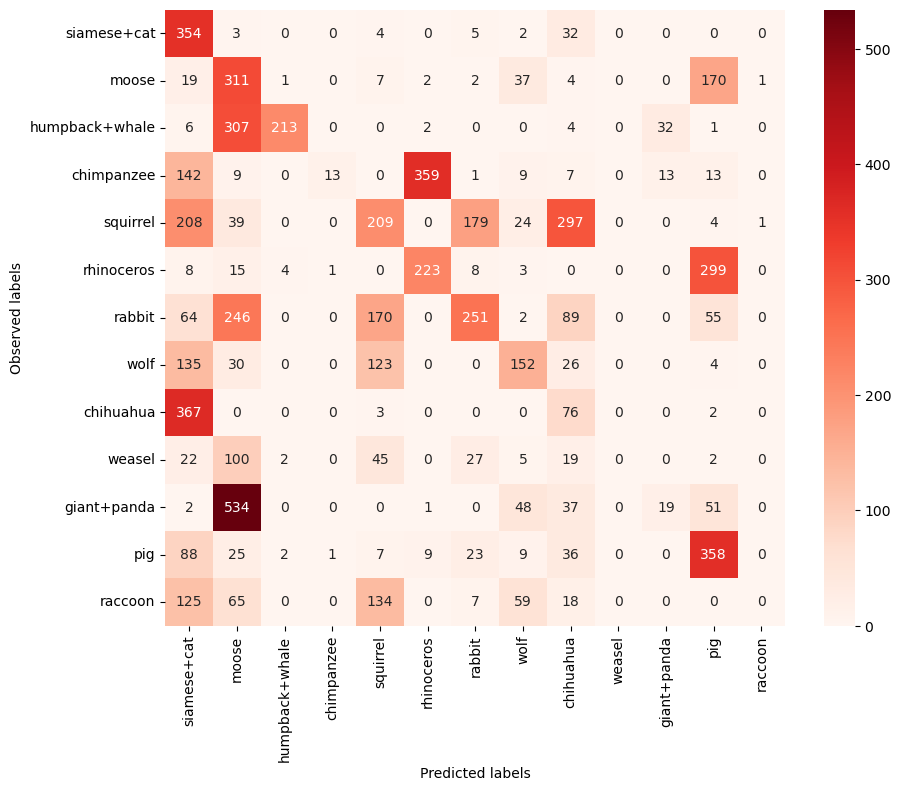

                precision    recall  f1-score   support

  ARTIODACTYLA       0.48      0.83      0.61      1677
     CARNIVORA       0.58      0.57      0.57      2640
    LAGOMORPHA       0.50      0.29      0.36       877
PERISSODACTYLA       0.37      0.40      0.39       561
      PRIMATES       0.87      0.02      0.04       566
      RODENTIA       0.30      0.22      0.25       961

      accuracy                           0.49      7282
     macro avg       0.52      0.39      0.37      7282
  weighted avg       0.52      0.49      0.46      7282

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.82766846 0.56742424 0.28620296 0.39750446 0.0229682  0.21748179]
Top_1_accuracy for UnSeen Validation split 01 -  0.386541684443672


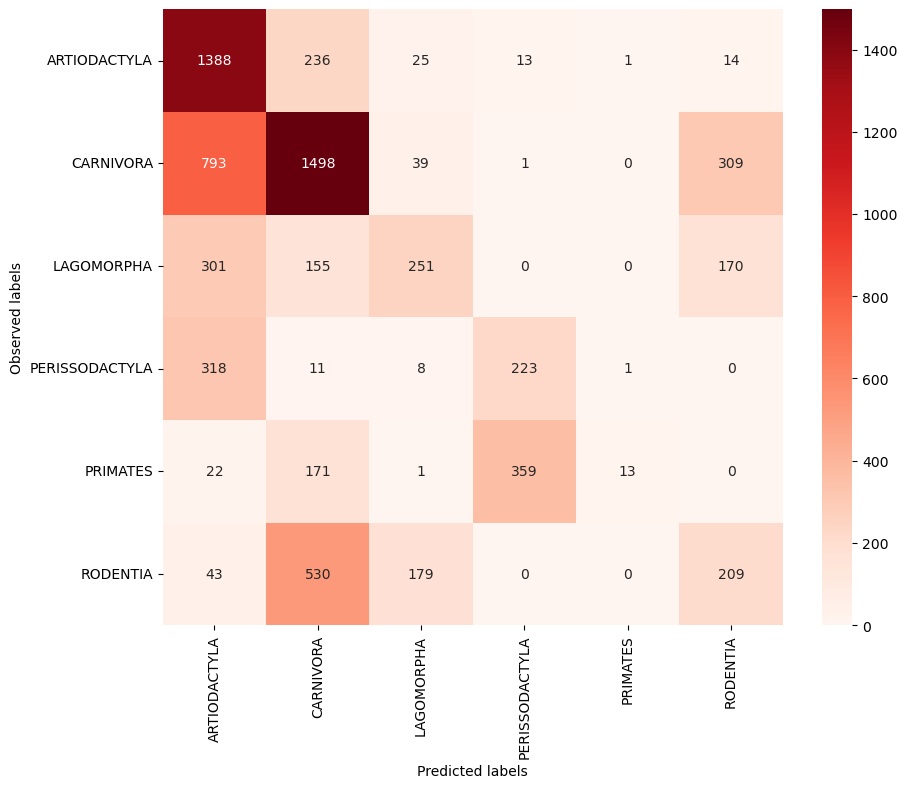

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.5434155925015149 
                 0         1
0      siamese+cat  0.972500
1            moose  0.718412
2   humpback+whale  0.810619
3       chimpanzee  0.618375
4         squirrel  0.363163
5       rhinoceros  0.575758
6           rabbit  0.484607
7             wolf  0.572340
8        chihuahua  0.984375
9           weasel  0.000000
10     giant+panda  0.261561
11             pig  0.695341
12         raccoon  0.007353 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.6739505248995628 
                 0         1
0      siamese+cat  0.982500
1            moose  0.826715
2   humpback+whale  0.966372
3       chimpanzee  0.780919
4         squirrel  0.515088
5       rhinoceros  0.689840
6           rabbit  0.695553
7             wolf  0.638298
8        chihuahua  0.986607
9           weasel  0.018018
10     giant+panda  0.802023
11             pig  0.795699
12         raccoon  0.063725 

 Top- 4  Accuracy per class 
 Top- 4  Accura

In [30]:
Train03 = CZSL(mode = "Train", 
               split = 3, 
               DNN = ProjectionNetwork2, 
               epochs = 16, 
               bs = 46, 
               numunits = 0, 
               lr = 0.12290408599069613, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.31868021549727776, 
               mom = 0.9102009362997737, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP3, 
               pred_type = 'Probabilistic', 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.5298                0.5098        0.5151                0.5125     +  1.3503
      2        0.4997                0.5359        0.4687                0.5589     +  1.0655
      3        0.4598                0.5738        0.4312                0.6066     +  1.2570
      4        0.4271                0.6049        0.4048                0.6487     +  1.0569
      5        0.4033                0.6298        0.3848                0.6824     +  1.3533
      6        0.3843                0.6517        0.3671                0.7113     +  1.0452
      7        0.3676                0.6717        0.3521                0.7355     +  1.3198
      8        0.3536                0.6908        0.3389                0.7558     +  1.2435
      9        0.3409                0.7075    

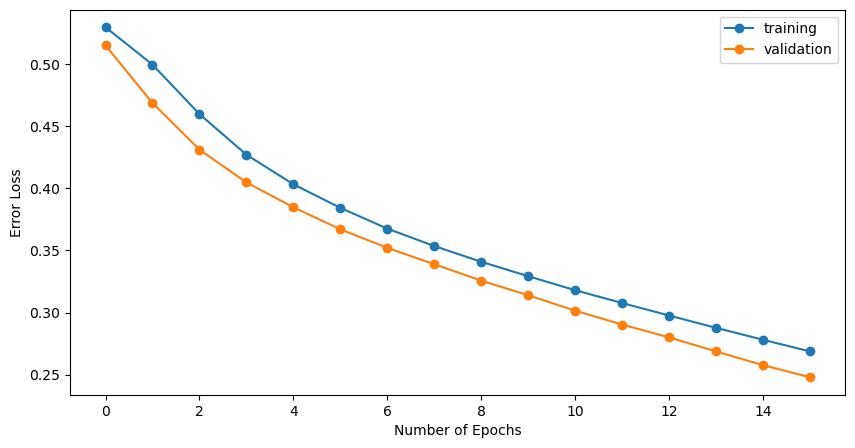

Trianing Recall Macro Curve


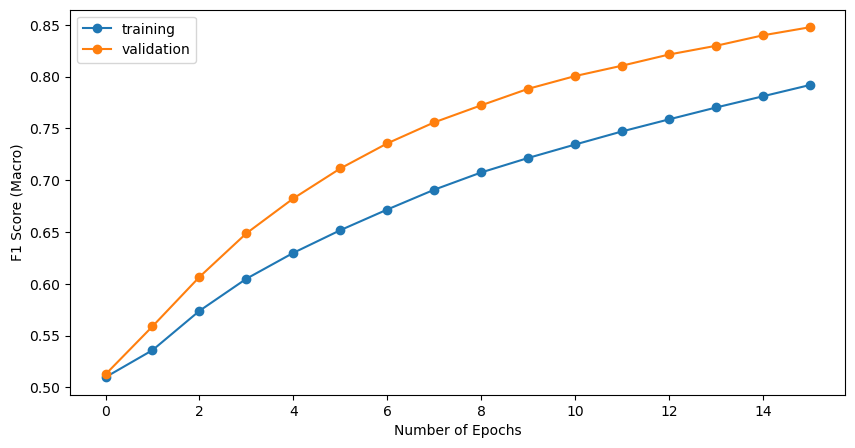

Unseen Class Labels
[ 7  9 23 24 30 31 34 41 47 50]
TSNE spatialisation of Unseen Classes


alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

       horse       1.00      0.01      0.01      1645
  blue+whale       0.11      1.00      0.20       174
       sheep       0.42      0.86      0.56      1420
        seal       0.00      0.00      0.00       988
         bat       0.00      0.00      0.00       383
     giraffe       0.17      0.13      0.15      1202
         rat       0.63      0.88      0.74       310
      bobcat       0.31      0.75      0.43       630
      walrus       0.08      0.20      0.12       215
     dolphin       0.55      0.02      0.04       946

    accuracy                           0.30      7913
   macro avg       0.33      0.38      0.22      7913
weighted avg       0.43      0.30      0.20      7913

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.00668693 1.         0.8584507  0.         0.         0.12895175
 0.87741935 0.74603175 0.2        0.01902748]
Top_1_accuracy for UnSeen Validation split 01 -  0.3836567966418943


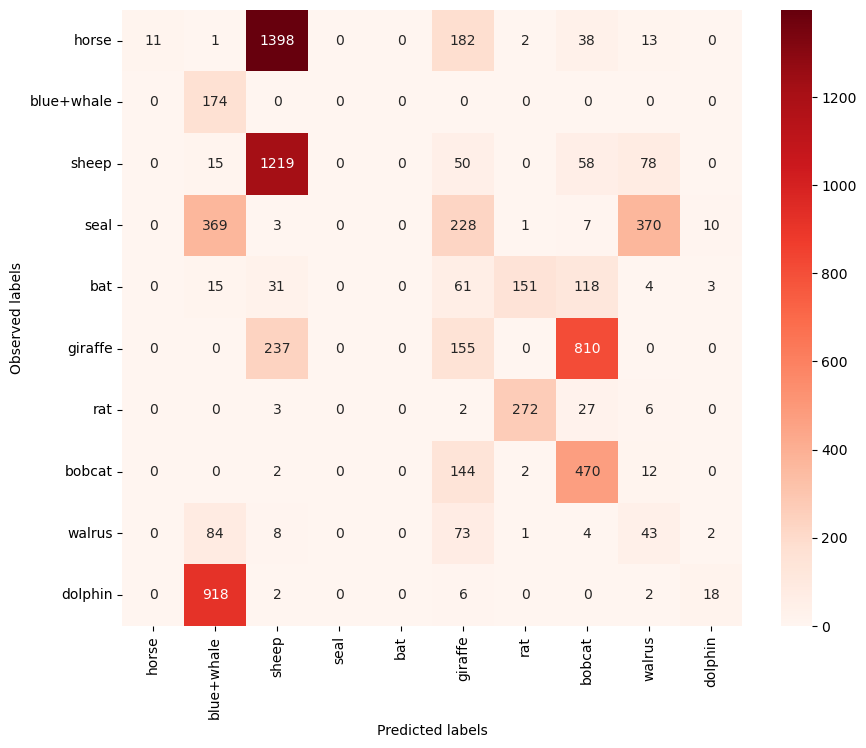

                precision    recall  f1-score   support

  ARTIODACTYLA       0.52      0.75      0.61      3742
     CARNIVORA       0.44      0.49      0.47      1833
    CHIROPTERA       0.00      0.00      0.00       383
PERISSODACTYLA       1.00      0.01      0.01      1645
      RODENTIA       0.63      0.88      0.74       310

      accuracy                           0.50      7913
     macro avg       0.52      0.43      0.37      7913
  weighted avg       0.58      0.50      0.43      7913

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.74665954 0.49427169 0.         0.00668693 0.87741935]
Top_1_accuracy for UnSeen Validation split 01 -  0.42500750220873906


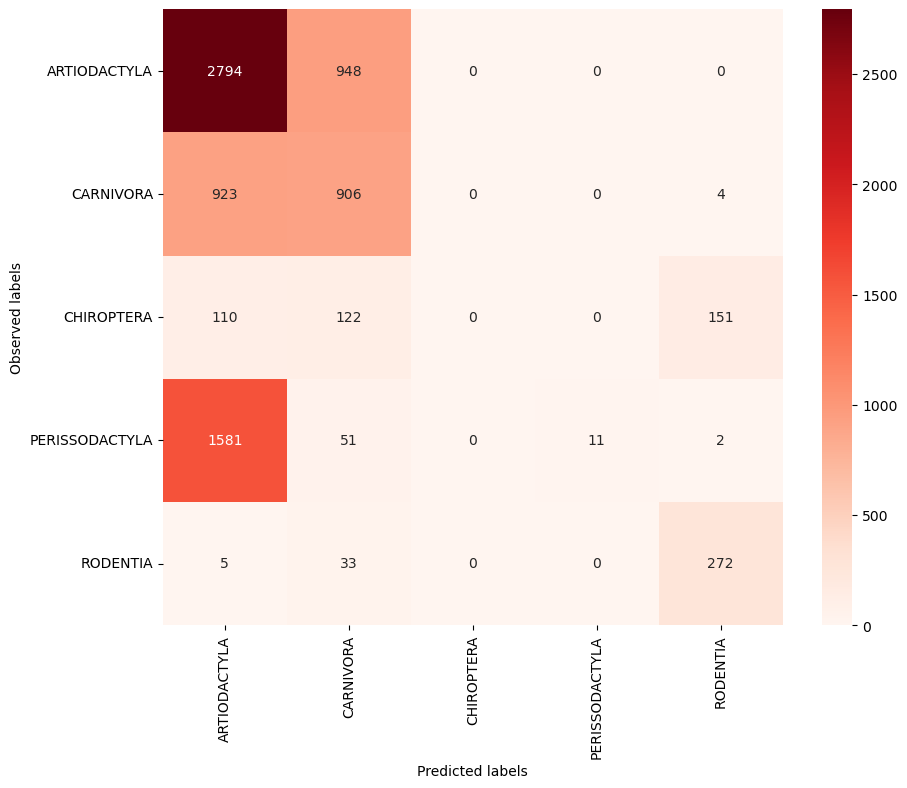

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.6042329624085186 
            0         1
0       horse  0.596960
1  blue+whale  1.000000
2       sheep  0.914789
3        seal  0.107287
4         bat  0.000000
5     giraffe  0.300333
6         rat  0.961290
7      bobcat  0.939683
8      walrus  0.674419
9     dolphin  0.547569 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.7485268918793102 
            0         1
0       horse  0.721581
1  blue+whale  1.000000
2       sheep  0.954930
3        seal  0.400810
4         bat  0.000000
5     giraffe  0.659734
6         rat  0.970968
7      bobcat  0.976190
8      walrus  0.893023
9     dolphin  0.908034 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.802575931163549 
            0         1
0       horse  0.773860
1  blue+whale  1.000000
2       sheep  0.975352
3        seal  0.595142
4         bat  0.018277
5     giraffe  0.731281
6         rat  0.977419
7      bobcat  0.988889
8      walrus  0.981395
9     dolphin  0.98

In [31]:
Test01 = CZSL(mode = "Test", 
               split = 3, 
               DNN = ProjectionNetwork2, 
               epochs = 16, 
               bs = 46, 
               numunits = 0, 
               lr = 0.12290408599069613, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.31868021549727776, 
               mom = 0.9102009362997737, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP_final, 
               pred_type = 'Probabilistic', 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

 # 11. CZSL on Unseen Test Set using non optimised parameters

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.3674                0.4834        0.3458                0.4938     +  4.0785
      2        0.3358                0.4980        0.3218                0.5084     +  2.3935
      3        0.3103                0.5158        0.2967                0.5280     +  2.7433
      4        0.2867                0.5367        0.2750                0.5477     +  2.9295
      5        0.2667                0.5577        0.2565                0.5684     +  2.6334
      6        0.2496                0.5792        0.2408                0.5902     +  2.5844
      7        0.2351                0.6001        0.2273                0.6107     +  2.6969
      8        0.2224                0.6199        0.2156                0.6293     +  2.5690
      9        0.2115                0.6383    

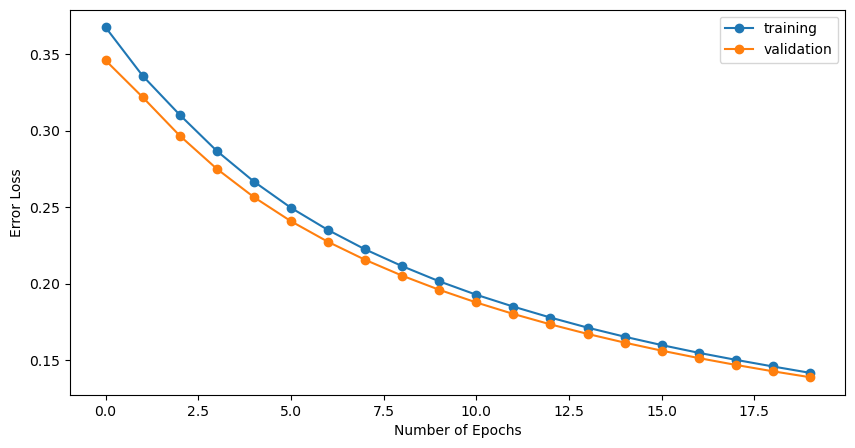

Trianing Recall Macro Curve


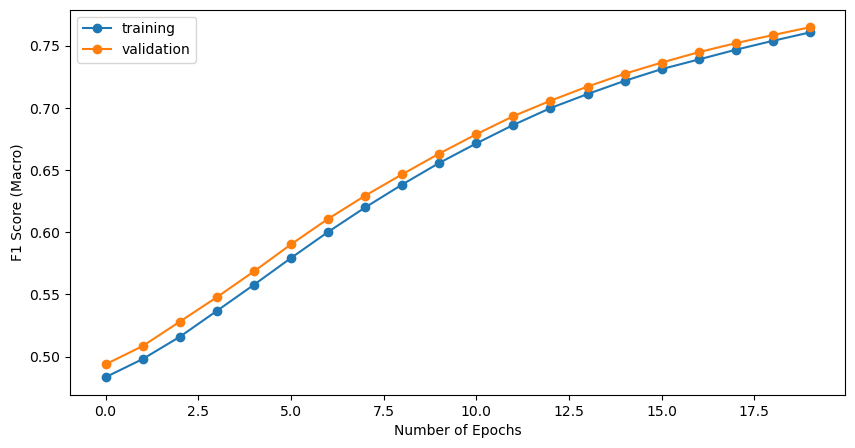

Unseen Class Labels
[ 7  9 23 24 30 31 34 41 47 50]
TSNE spatialisation of Unseen Classes


alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

       horse       0.00      0.00      0.00      1645
  blue+whale       0.38      0.93      0.54       174
       sheep       0.34      0.87      0.49      1420
        seal       0.00      0.00      0.00       988
         bat       0.00      0.00      0.00       383
     giraffe       0.51      0.73      0.60      1202
         rat       0.24      0.23      0.23       310
      bobcat       0.11      0.13      0.12       630
      walrus       0.25      0.25      0.25       215
     dolphin       0.77      0.67      0.72       946

    accuracy                           0.39      7913
   macro avg       0.26      0.38      0.30      7913
weighted avg       0.26      0.39      0.30      7913

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.         0.93103448 0.87394366 0.         0.         0.73294509
 0.23225806 0.12857143 0.25116279 0.66913319]
Top_1_accuracy for UnSeen Validation split 01 -  0.38190487124188327


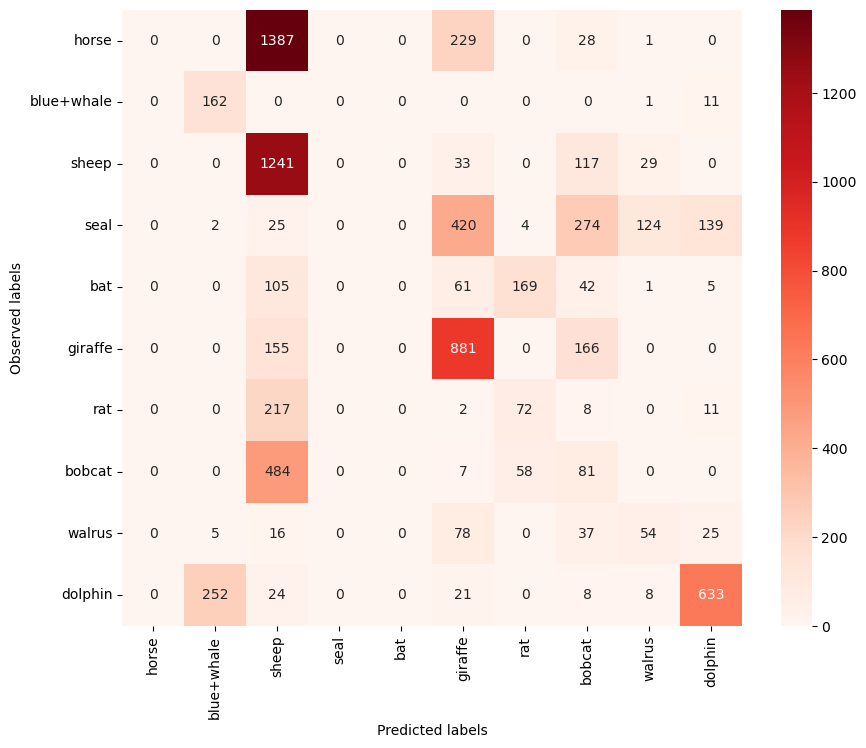

                precision    recall  f1-score   support

  ARTIODACTYLA       0.51      0.91      0.66      3742
     CARNIVORA       0.58      0.31      0.41      1833
    CHIROPTERA       0.00      0.00      0.00       383
PERISSODACTYLA       0.00      0.00      0.00      1645
      RODENTIA       0.24      0.23      0.23       310

      accuracy                           0.51      7913
     macro avg       0.27      0.29      0.26      7913
  weighted avg       0.39      0.51      0.41      7913

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.9120791  0.31096563 0.         0.         0.23225806]
Top_1_accuracy for UnSeen Validation split 01 -  0.29106055934302844


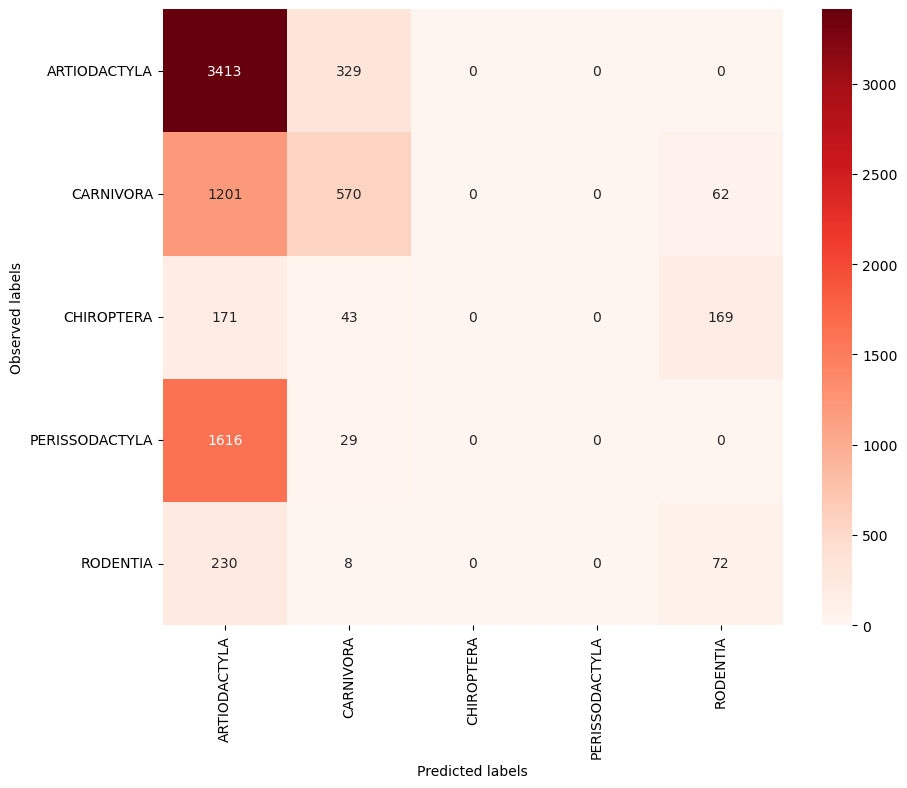

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.5465528209446368 
            0         1
0       horse  0.017021
1  blue+whale  0.977011
2       sheep  0.952817
3        seal  0.003036
4         bat  0.000000
5     giraffe  0.993344
6         rat  0.793548
7      bobcat  0.296825
8      walrus  0.460465
9     dolphin  0.971459 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.634712590078661 
            0         1
0       horse  0.293617
1  blue+whale  0.982759
2       sheep  0.990141
3        seal  0.011134
4         bat  0.000000
5     giraffe  1.000000
6         rat  0.938710
7      bobcat  0.504762
8      walrus  0.641860
9     dolphin  0.984144 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.7594257424080173 
            0         1
0       horse  0.851064
1  blue+whale  0.994253
2       sheep  1.000000
3        seal  0.070850
4         bat  0.000000
5     giraffe  1.000000
6         rat  0.977419
7      bobcat  0.934921
8      walrus  0.772093
9     dolphin  0.99

In [15]:
Test02 = CZSL(mode = "Test", 
               split = 3, 
               DNN = ProjectionNetwork1, 
               epochs = 20, 
               bs = 16, 
               numunits = 1024, 
               lr = 0.1, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.2, 
               mom = 0, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP_final, 
               pred_type = 'Probabilistic', 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard